Imports

In [1]:
import os
import time
import mne_connectivity
import numpy as np
import mne
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

Ensure Matplotlib uses the Qt5Agg backend for plotting functions

In [2]:
#  matplotlib.use('Qt5Agg')
annot_kwargs = dict(fontsize=12, fontweight='bold',
                    xycoords="axes fraction", ha='right', va='center')
fontsize = 8
params = {'font.size': fontsize,
          'axes.labelsize': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'axes.titlesize': fontsize + 2,
          'figure.max_open_warning': 200,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.grid': True,
          'lines.linewidth': 1
          }
plt.rcParams.update(params)

Configure to use Cuda

In [3]:
try:
    mne.set_config('MNE_USE_CUDA', 'true')
except TypeError as err:
    print(err)

Choose channels from the raw edf file to use

In [4]:
# good channels: [4,5,6,7,8,9,10,11,12,13,14,15,16,17]
# all channels ['TIME_STAMP_s', 'TIME_STAMP_ms', 'COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'HighBitFlex', 'SaturationFlag', 'RAW_CQ', 'BATTERY', 'BATTERY_PERCENT', 'MarkerIndex', 'MarkerType', 'MarkerValueInt', 'MARKER_HARDWARE', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_OVERALL', 'EQ_SampleRateQua', 'EQ_OVERALL', 'EQ_AF3', 'EQ_F7', 'EQ_F3', 'EQ_FC5', 'EQ_T7', 'EQ_P7', 'EQ_O1', 'EQ_O2', 'EQ_P8', 'EQ_T8', 'EQ_FC6', 'EQ_F4', 'EQ_F8', 'EQ_AF4', 'CQ_CMS', 'CQ_DRL']
stim_channels = ['MarkerValueInt']
exclude = ['MarkerType', 'MARKER_HARDWARE', 'MarkerIndex', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'COUNTER', 'INTERPOLATED', 'HighBitFlex', 'SaturationFlag', 'RAW_CQ', 'BATTERY', 'BATTERY_PERCENT', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_OVERALL', 'EQ_SampleRateQua', 'EQ_OVERALL', 'EQ_AF3', 'EQ_F7', 'EQ_F3', 'EQ_FC5', 'EQ_T7', 'EQ_P7', 'EQ_O1', 'EQ_O2', 'EQ_P8', 'EQ_T8', 'EQ_FC6', 'EQ_F4', 'EQ_F8', 'EQ_AF4', 'CQ_CMS', 'CQ_DRL']
#  eog_channels = ['AF3', 'AF4']

Import EDF

In [5]:
#  edf file name here
edf_file_name = 'EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.06.21T14.54.07.04.00'
data_raw_file = f"{os.getcwd()}\\BCI Evasion 2\\EEGExports\\{edf_file_name}.edf"
raw = mne.io.read_raw_edf(data_raw_file, stim_channel=stim_channels, exclude=exclude, preload=True)

Extracting EDF parameters from D:\Pycharm Projects\EEG-Game\BCI Evasion 2\EEGExports\EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.06.15T16.11.10.04.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9471  =      0.000 ...    73.992 secs...


Set up the montage for this data

In [6]:
# Form the 10-20 montage
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()
# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info

Apply montage to the raw data and plot

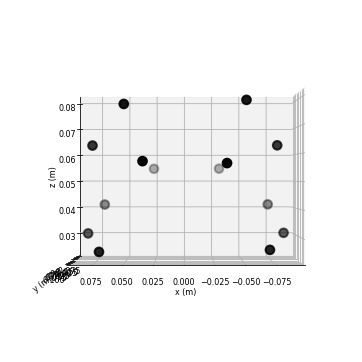

Using matplotlib as 2D backend.
Opening raw-browser...


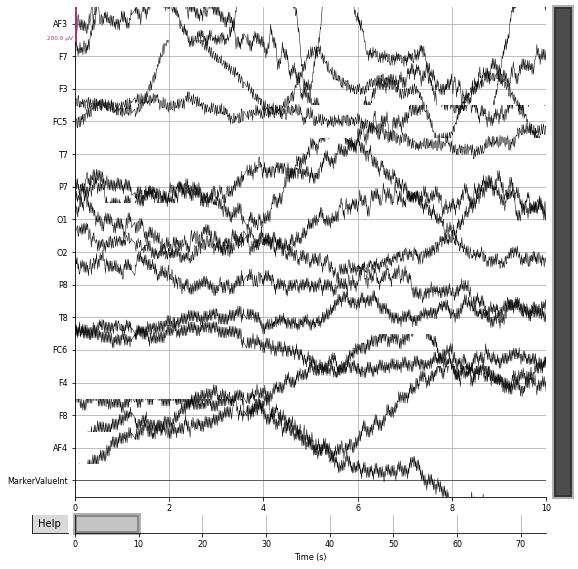

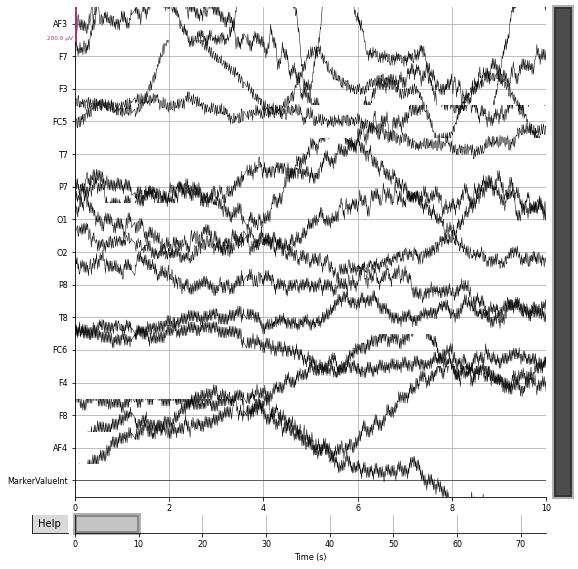

In [7]:
raw.set_montage(mont1020_new)
raw.plot_sensors(kind='3d', ch_type='eeg')
raw.plot(scalings=0.0001)

Preprocess Data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 845 samples (6.602 sec)

Effective window size : 16.000 (s)
Effective window size : 16.000 (s)


C:\Users\Joshu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


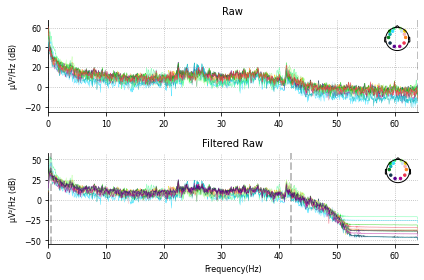

In [8]:
filtered_raw = raw.copy().filter(
    0.5, 42, l_trans_bandwidth='auto', h_trans_bandwidth='auto',
    filter_length='auto', phase='zero', fir_window='hamming',
    fir_design='firwin')
fig, ax = plt.subplots(2)
raw.plot_psd(ax=ax[0], show=False)
filtered_raw.plot_psd(ax=ax[1], show=False)
ax[0].set_title('Raw')
ax[1].set_title('Filtered Raw')
ax[1].set_xlabel('Frequency(Hz)')
fig.set_tight_layout(True)
plt.show()

Perform ICA preprocessing

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.3s.


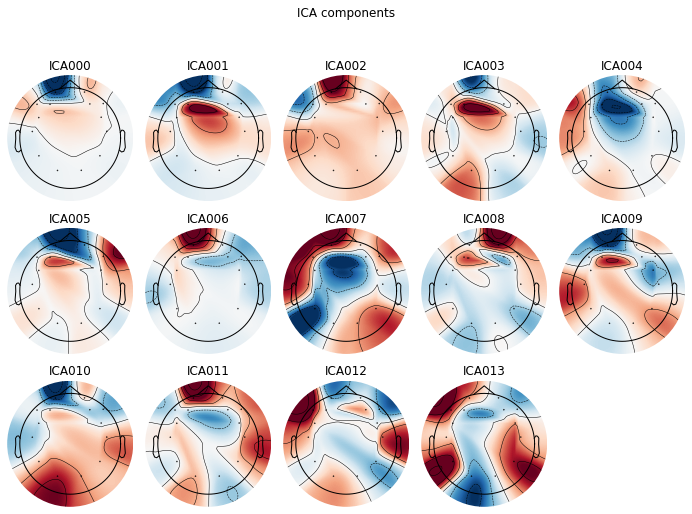

[<MNEFigure size 702x526.68 with 14 Axes>]

In [9]:
ica = mne.preprocessing.ICA(method='picard', n_components=14, random_state=0, max_iter=100000)
ica.fit(filtered_raw)
ica.plot_components(outlines='skirt')

Extract bad channels

In [10]:
bad_idx, scores = ica.find_bads_eog(raw.copy(), ch_name=['AF3', 'AF4'], threshold=2.5)
print(bad_idx)

Using EOG channels: AF3, AF4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.2

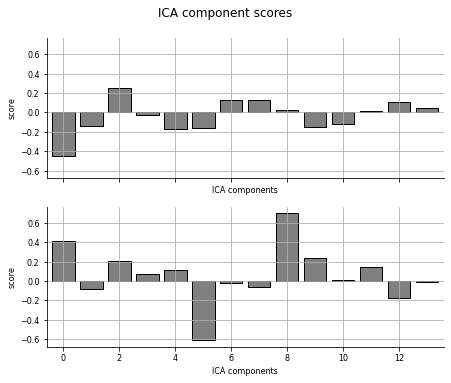

[]
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components


<RawEDF | EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.06.15T16.11.10.04.00.edf, 15 x 9472 (74.0 s), ~1.1 MB, data loaded>

In [11]:
# barplot of ICA component "ECG match" scores
ica.plot_scores(scores)

# plot diagnostics
if len(bad_idx) > 0:
    ica.plot_properties(raw, picks=bad_idx)

ica.exclude=bad_idx
print(ica.exclude)
reconst_raw = raw.copy()
ica.apply(reconst_raw)


Compare original to ICA filtered eeg data

Opening raw-browser...


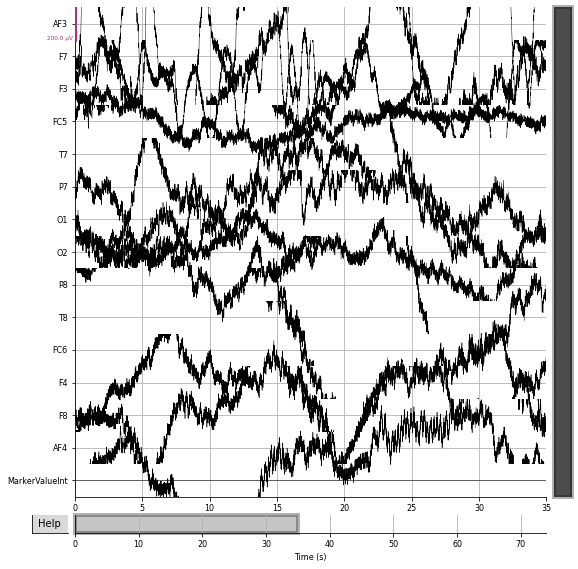

Opening raw-browser...


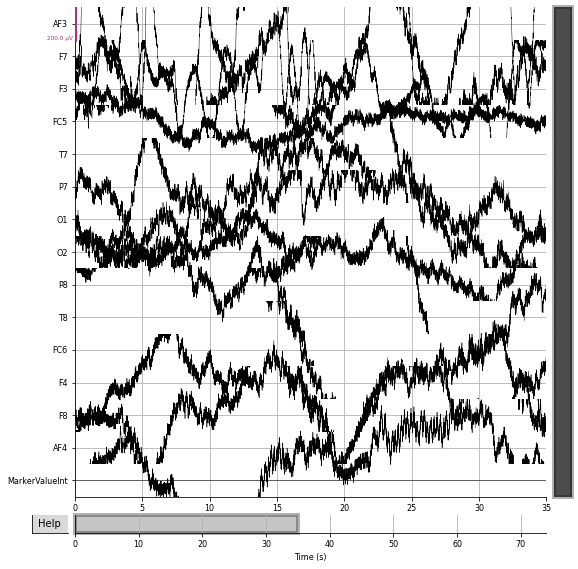

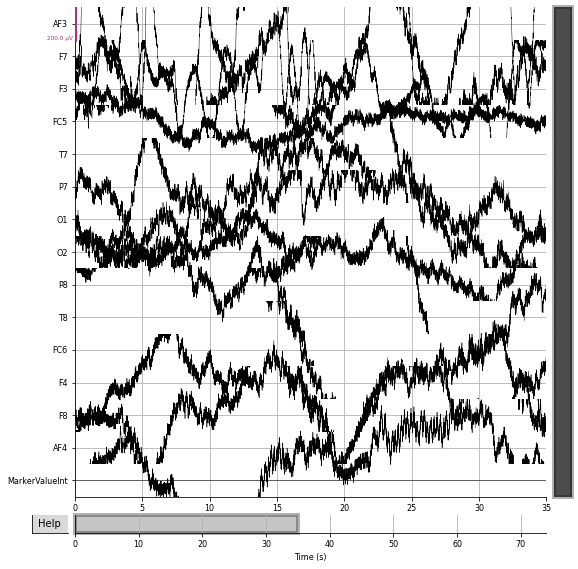

In [12]:
raw.plot(scalings=0.0001, duration=35)
reconst_raw.plot(scalings=0.0001, duration=35)

Extract events from the raw data for event based analysis. Create dictionary for event types

In [13]:
# events = mne.find_events(filtered_raw)
# print(events)
# event_types = {
#     'new_game':1,
#     'left':2,
#     'right':3,
#     'lift':4,
#     'drop':5
#     }

Find Epochs based on equally lengthed time segments instead of events

In [14]:
epochs = mne.make_fixed_length_epochs(raw, duration=8, preload=False, overlap=7)

Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated


Determine connectivity for epoch set. Set connectivity method, frequency bands, and connectivity threshold.

In [15]:
from EpochToCorrelationMatrix import EpochsToCorrelation
correlated_data = EpochsToCorrelation(epochs, method='plv', freq='beta', threshold=None)

Using data from preloaded Raw for 67 events and 1024 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 12 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 141 samples (1.102 sec)



D:\Pycharm Projects\EEG-Game\EpochToCorrelationMatrix.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  phase_difference_mat[i] = x


Plot correlation matrix for each epoch

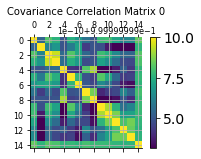

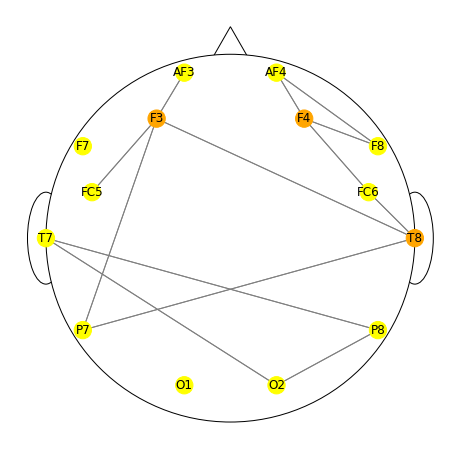

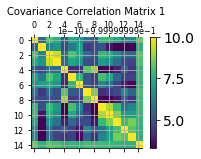

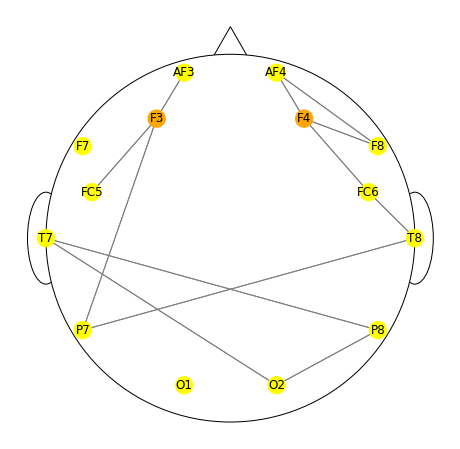

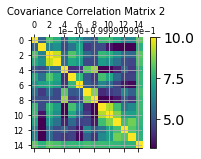

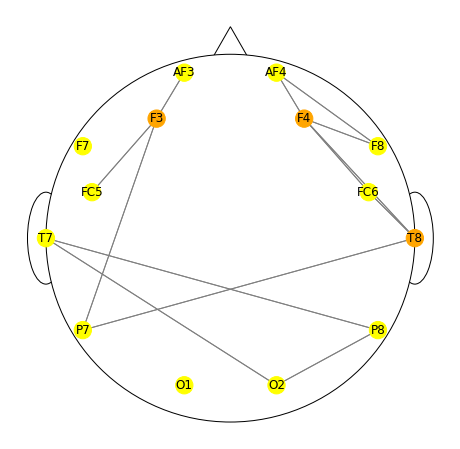

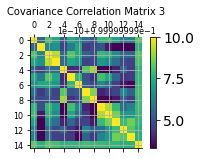

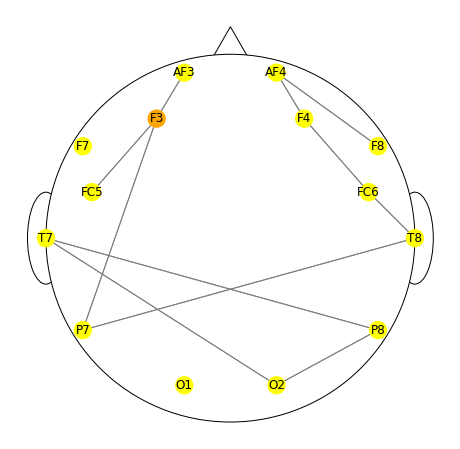

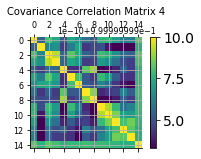

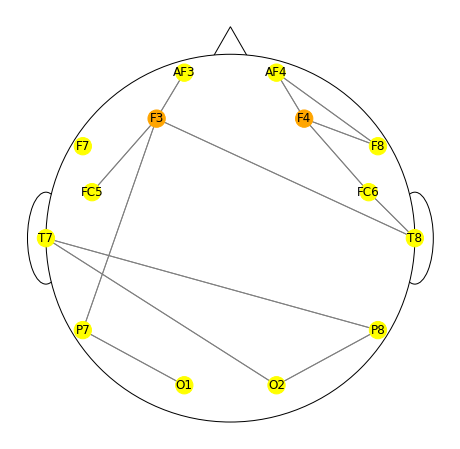

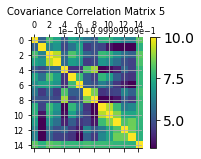

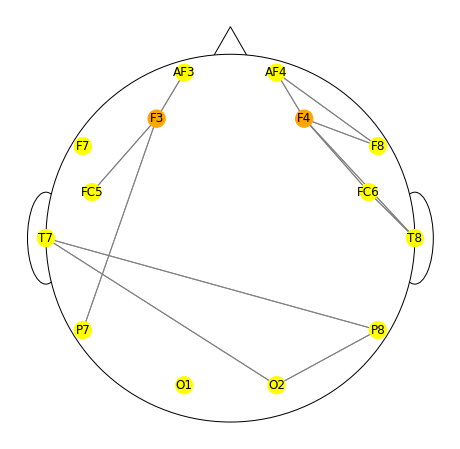

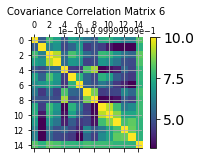

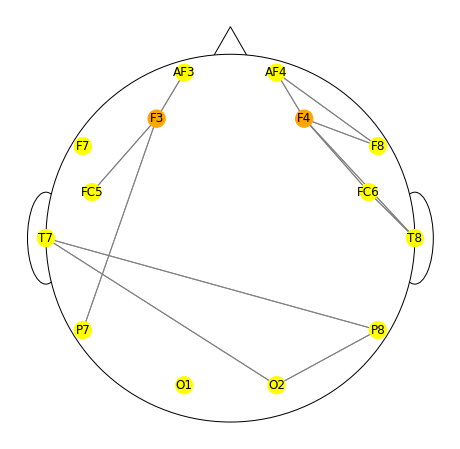

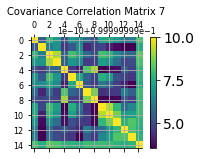

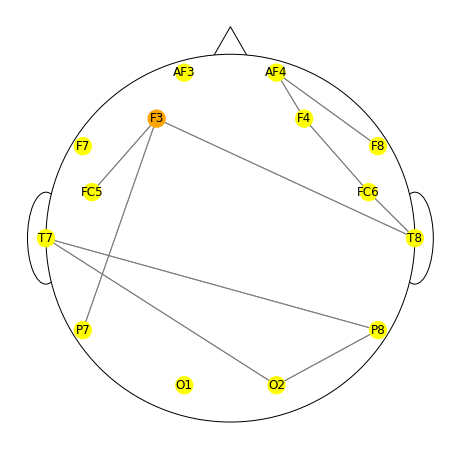

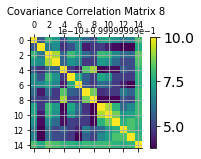

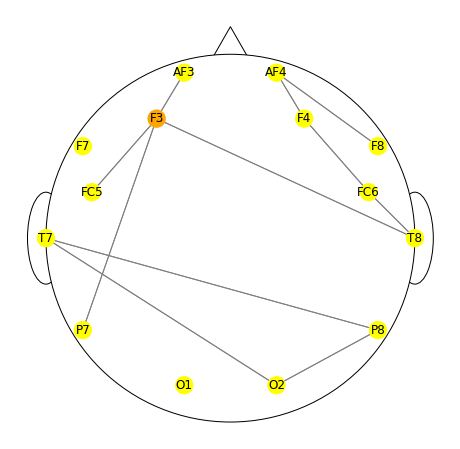

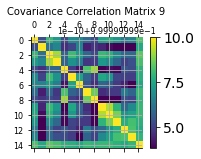

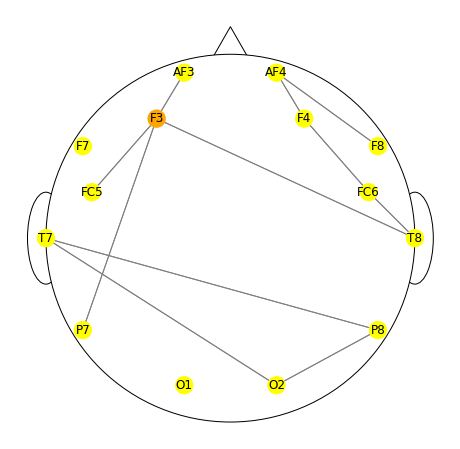

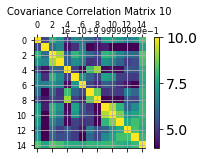

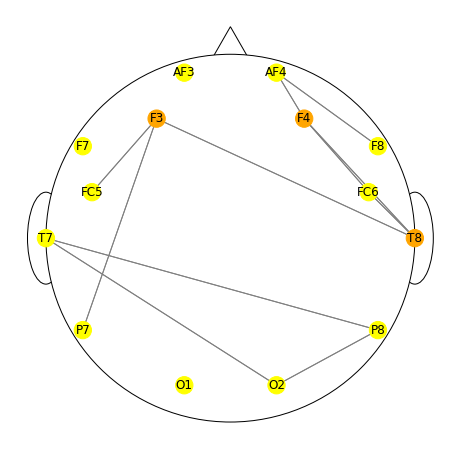

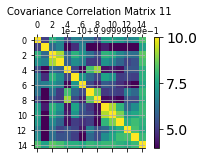

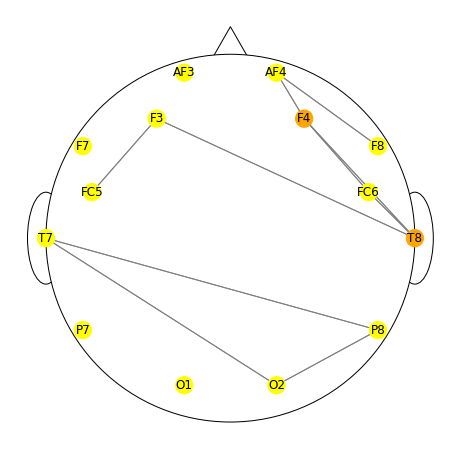

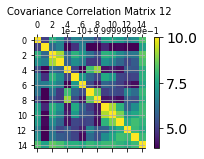

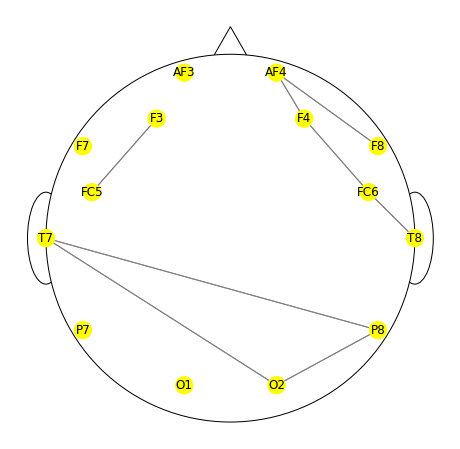

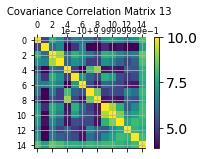

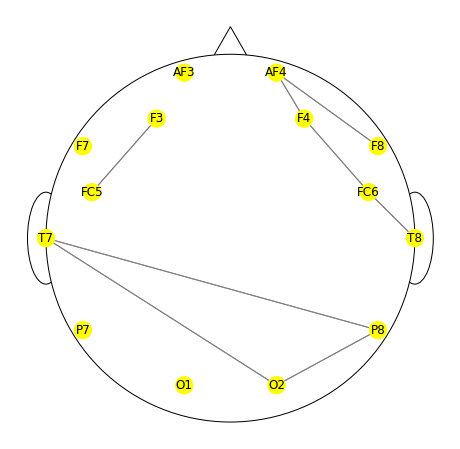

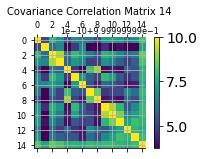

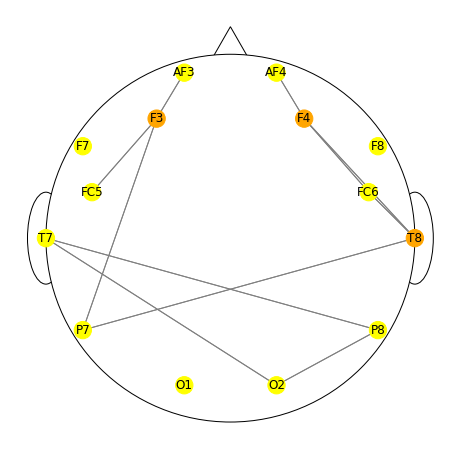

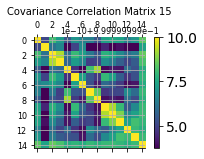

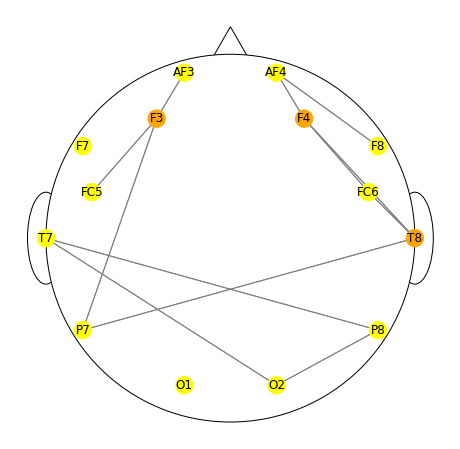

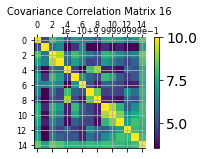

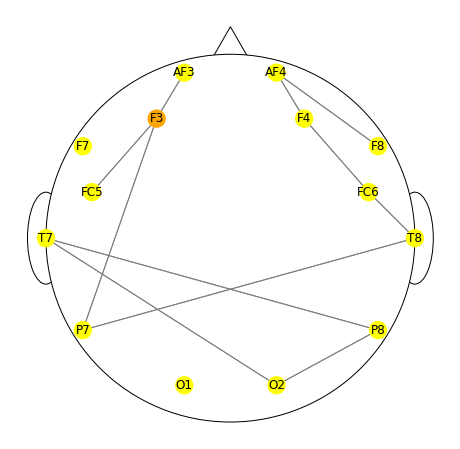

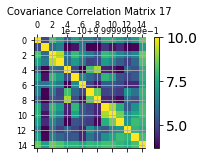

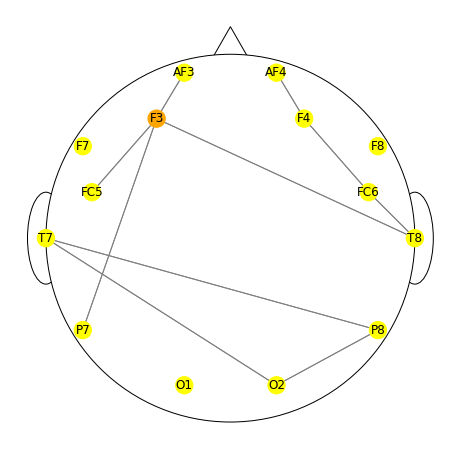

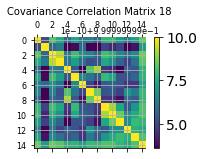

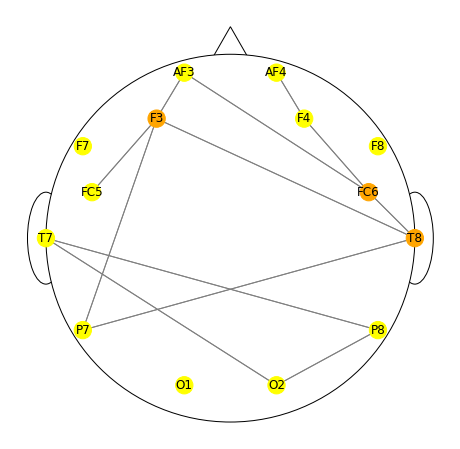

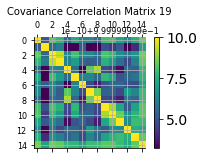

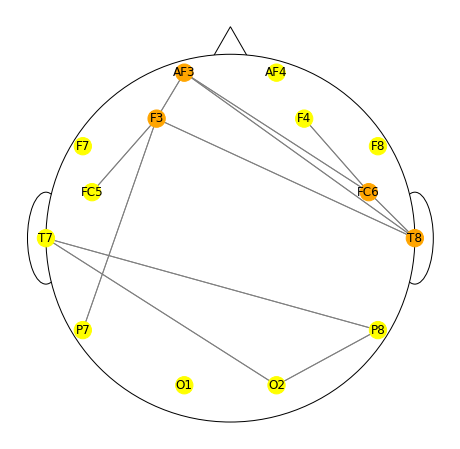

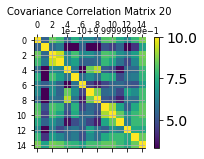

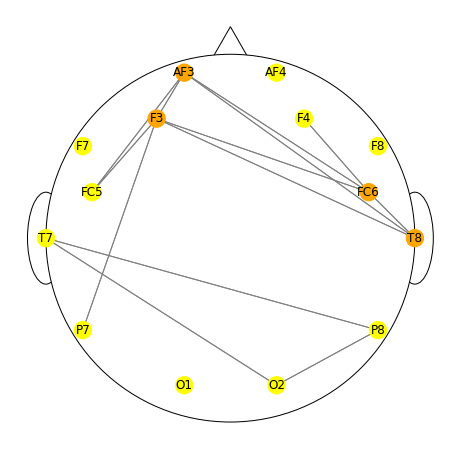

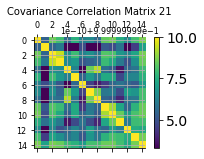

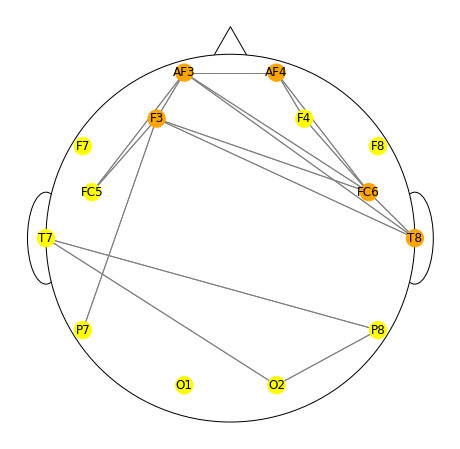

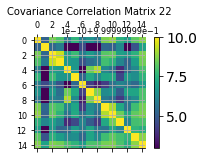

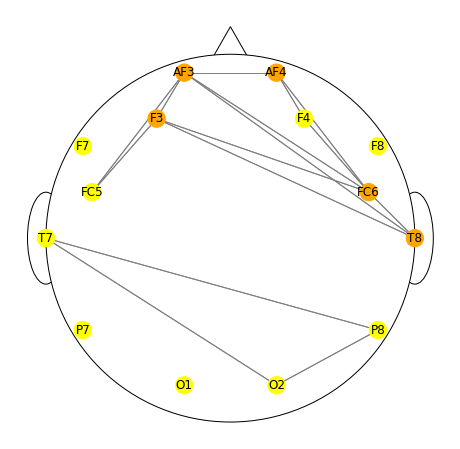

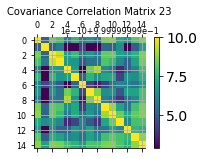

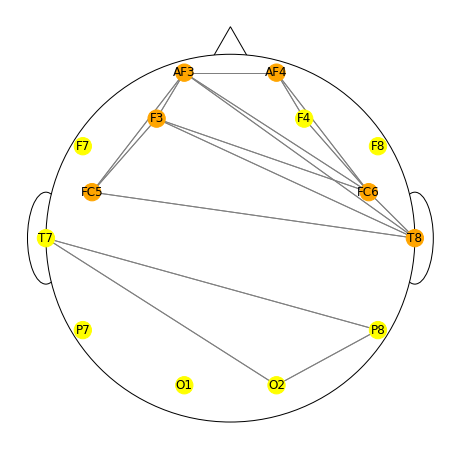

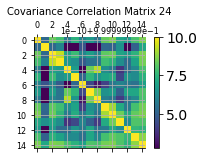

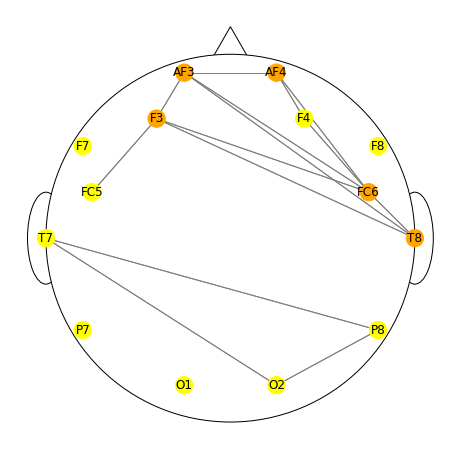

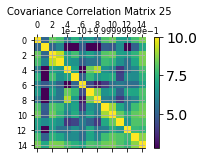

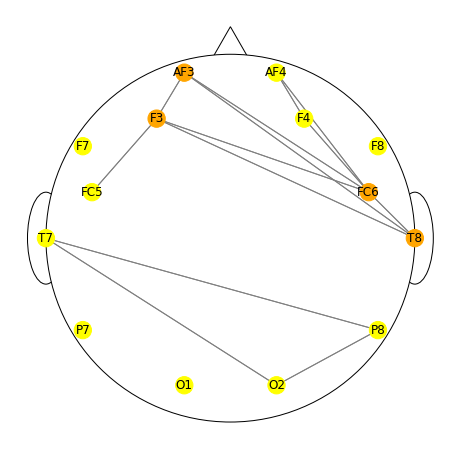

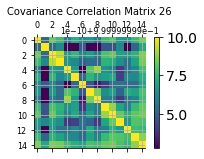

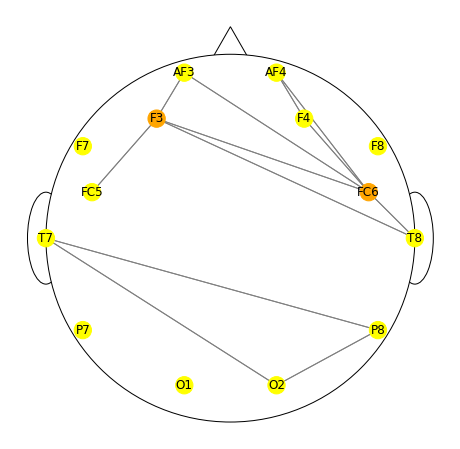

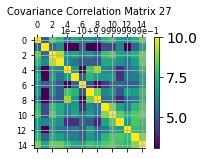

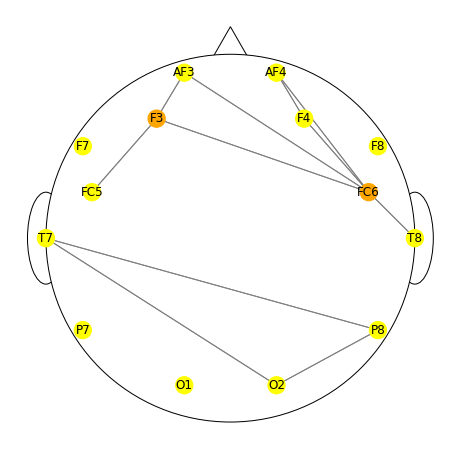

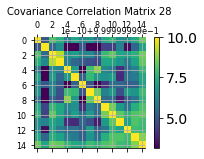

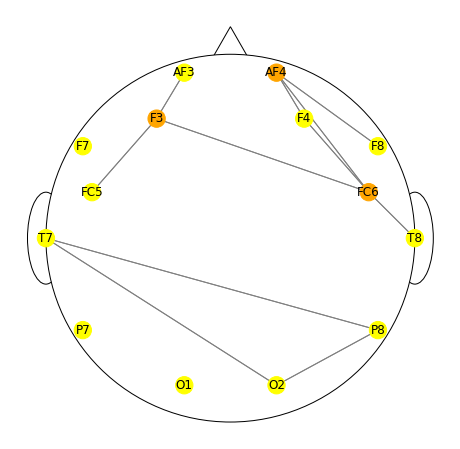

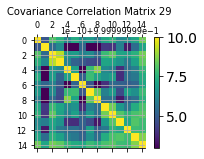

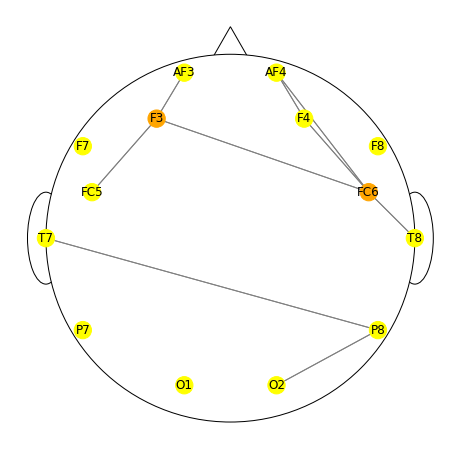

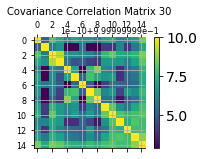

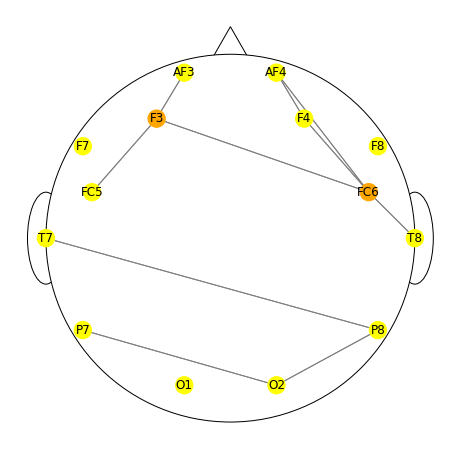

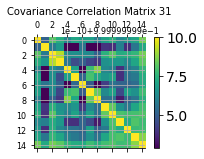

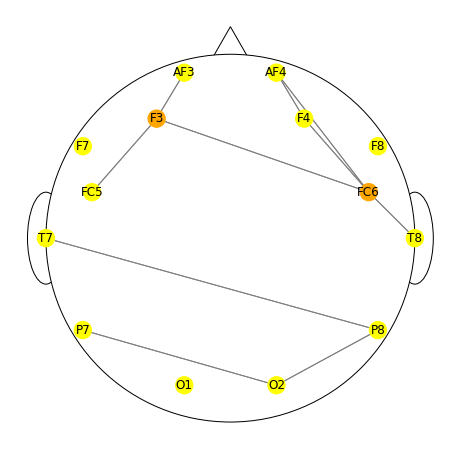

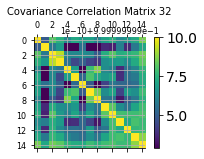

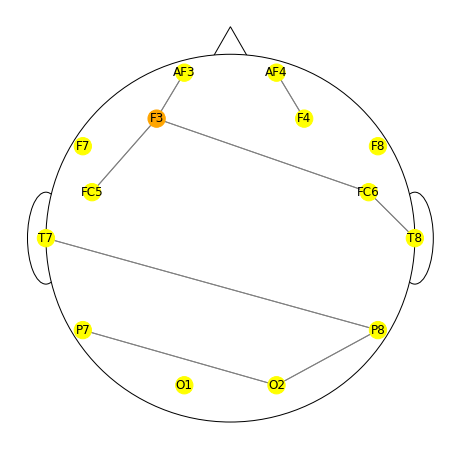

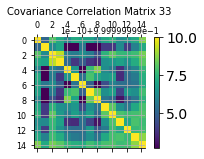

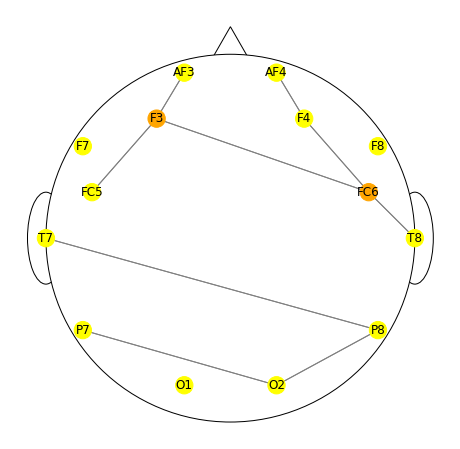

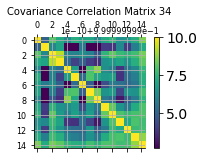

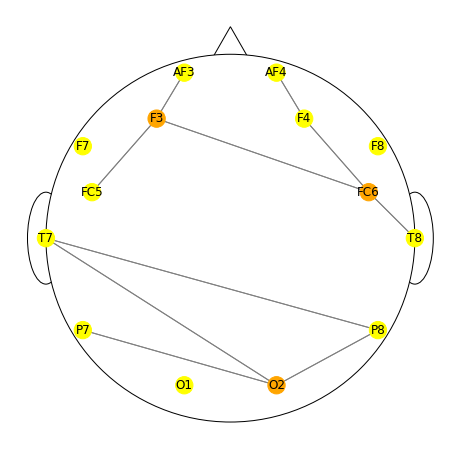

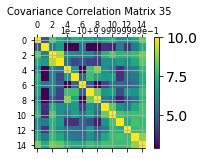

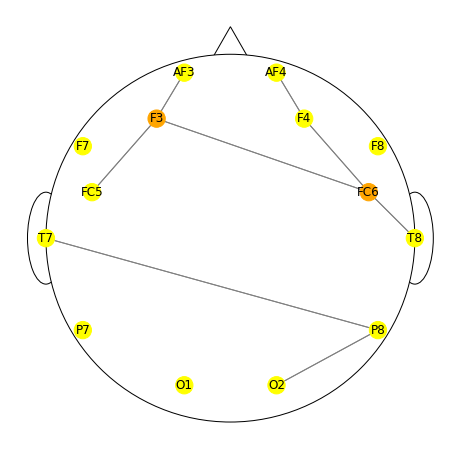

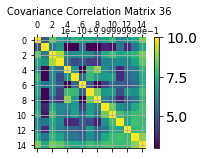

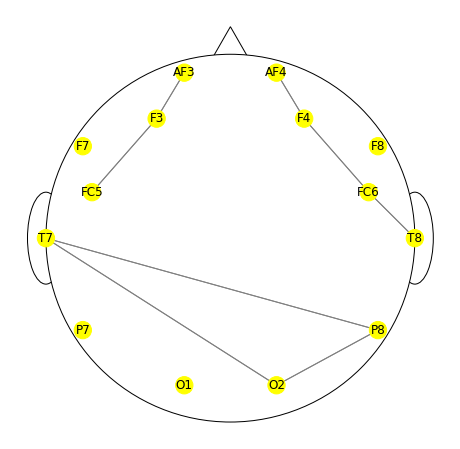

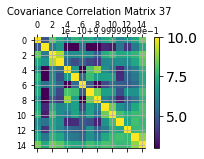

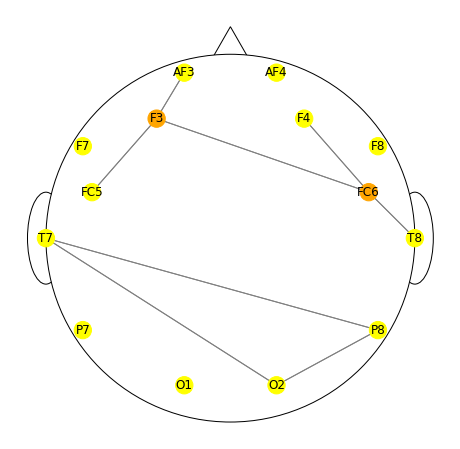

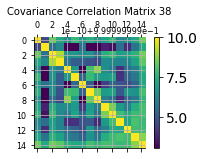

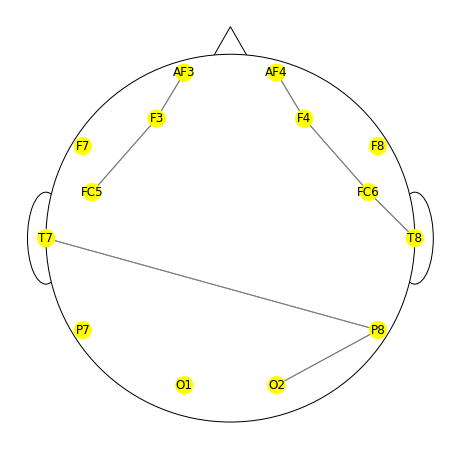

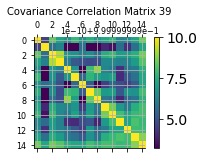

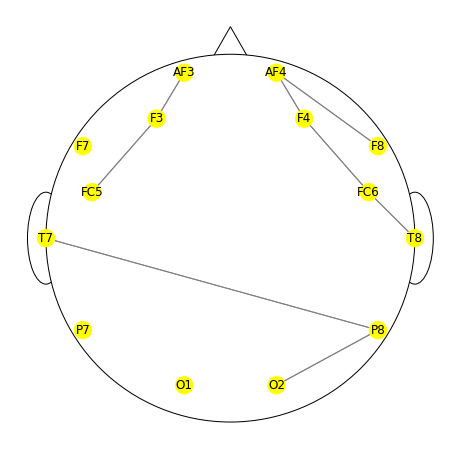

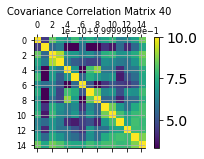

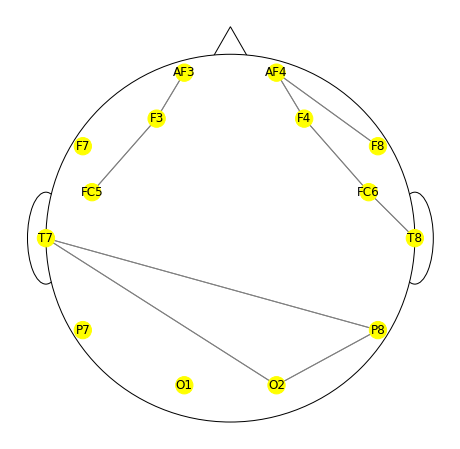

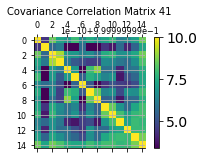

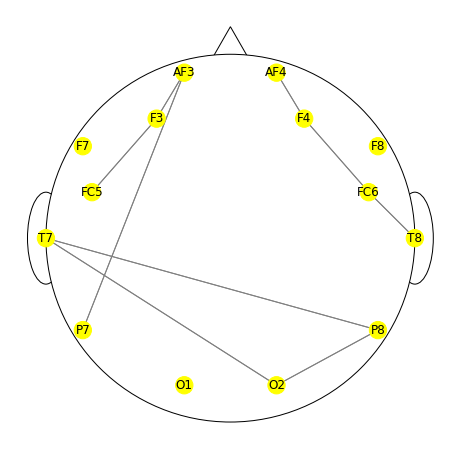

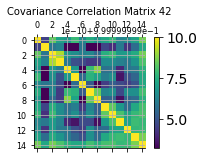

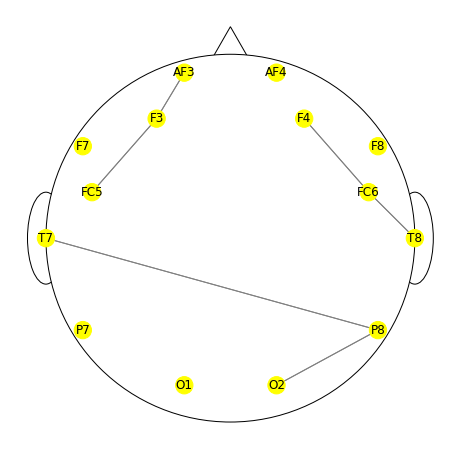

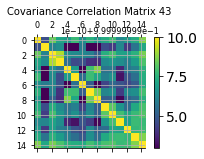

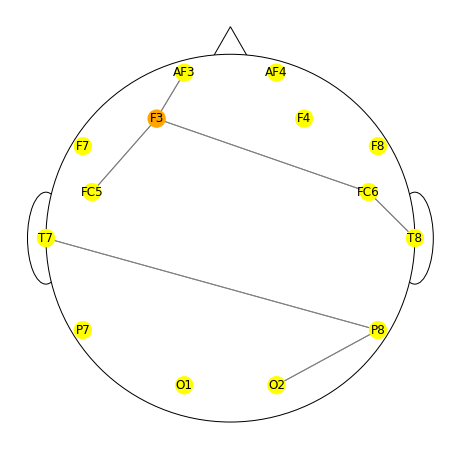

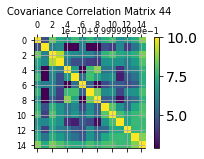

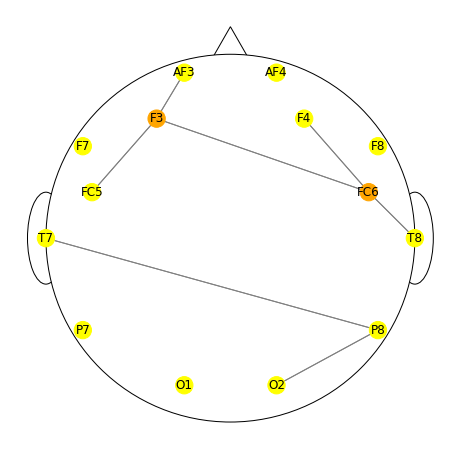

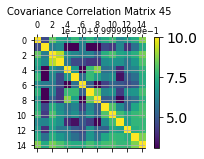

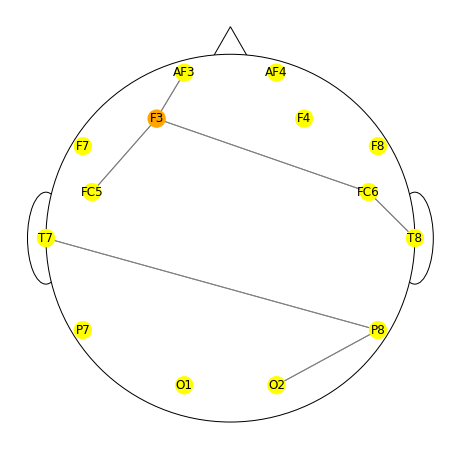

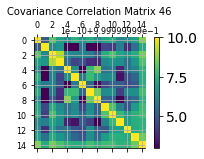

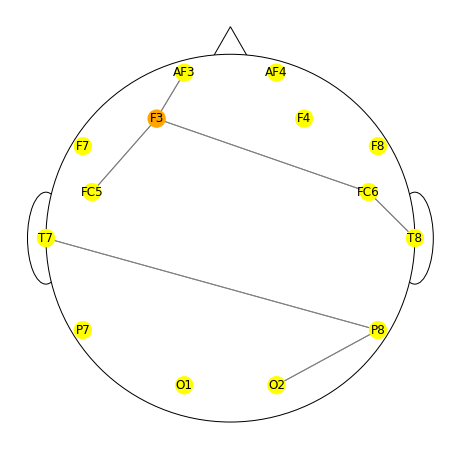

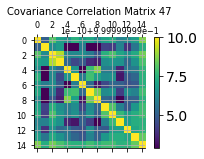

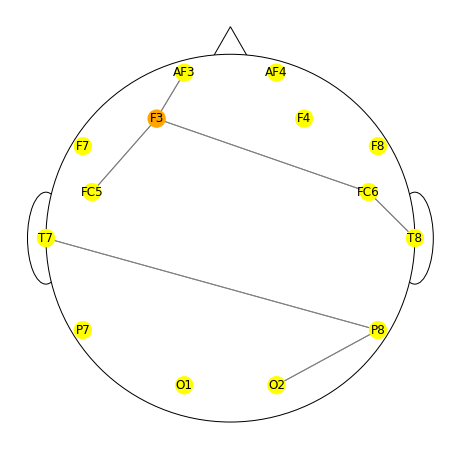

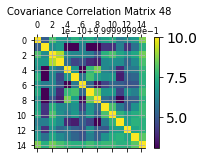

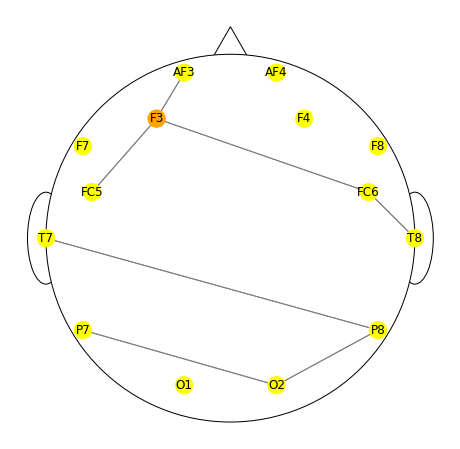

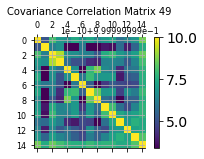

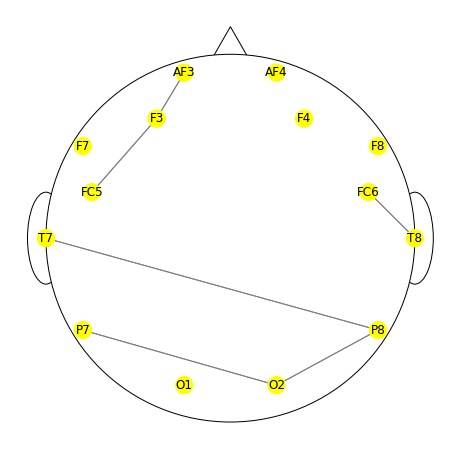

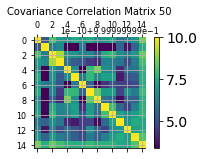

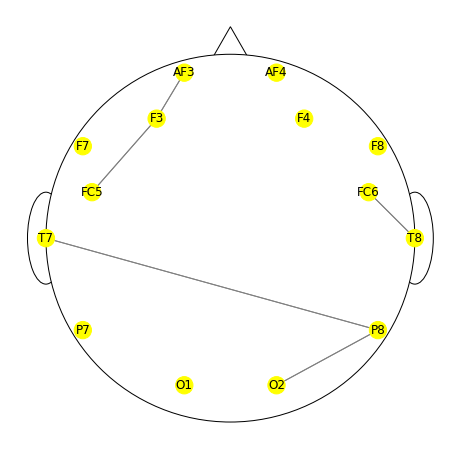

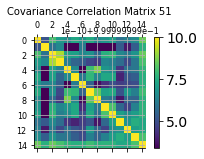

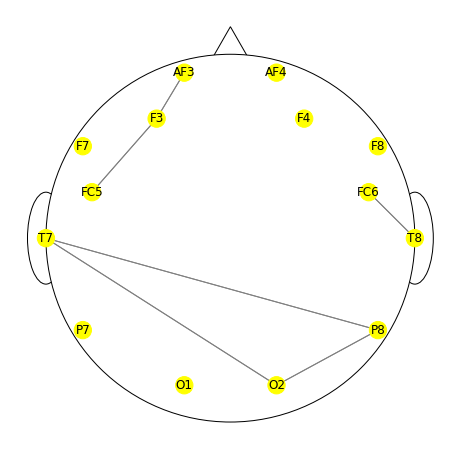

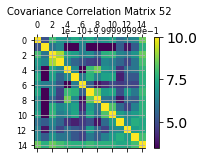

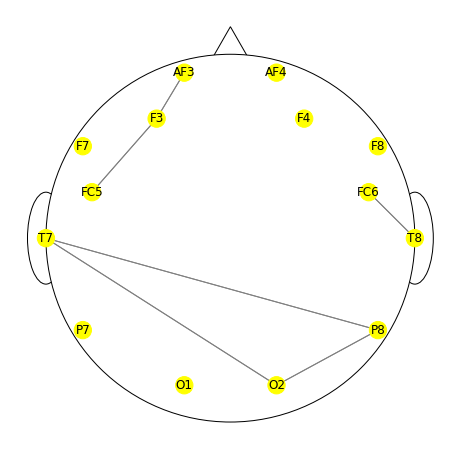

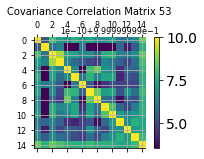

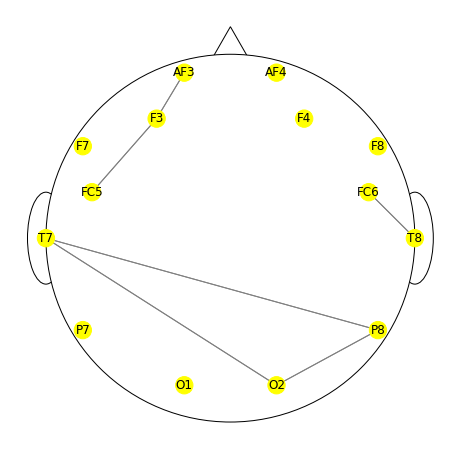

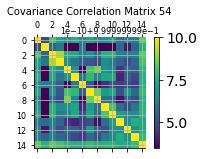

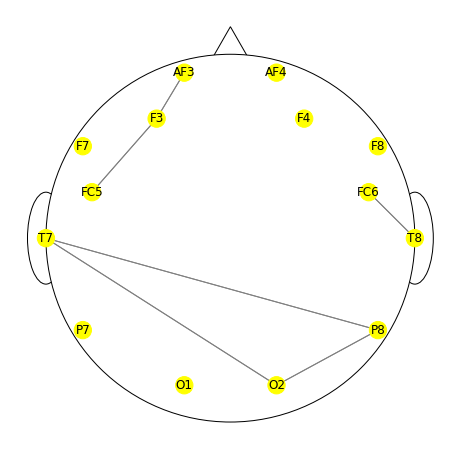

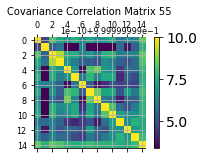

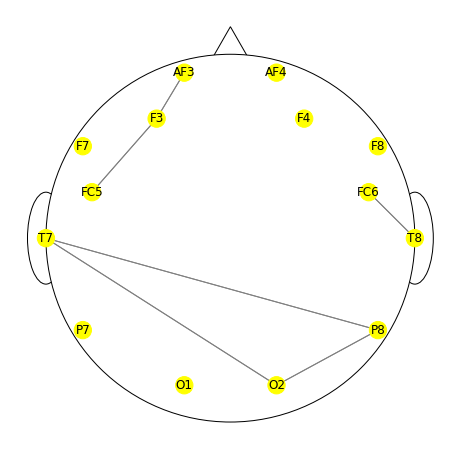

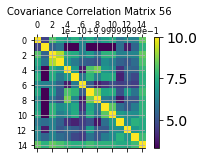

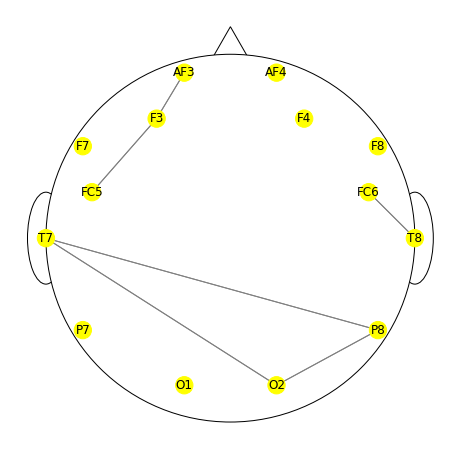

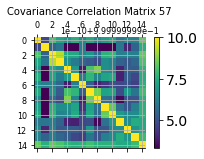

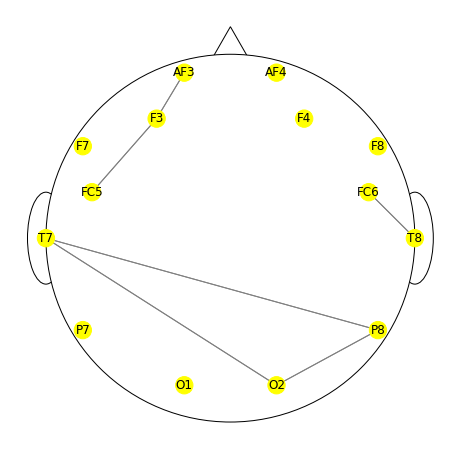

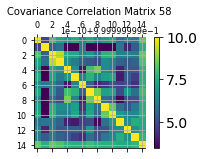

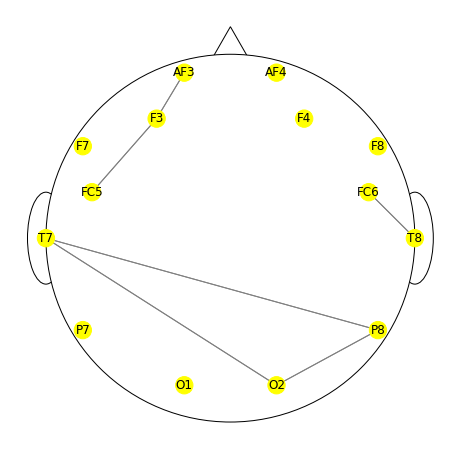

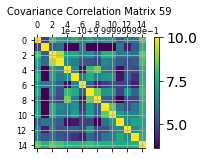

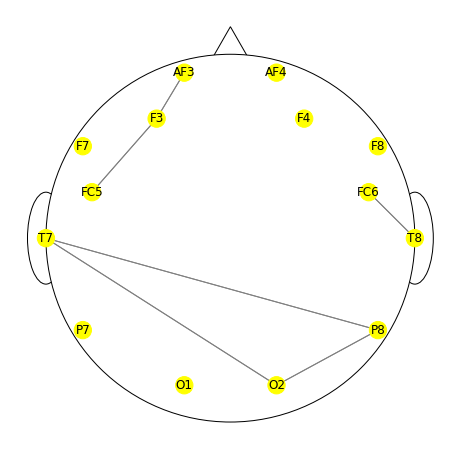

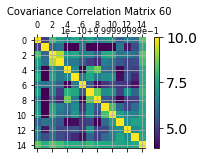

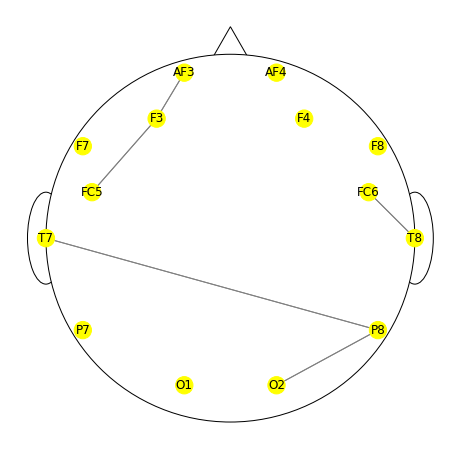

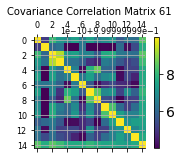

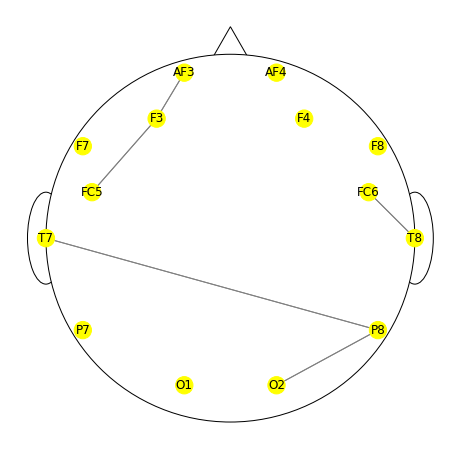

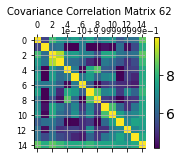

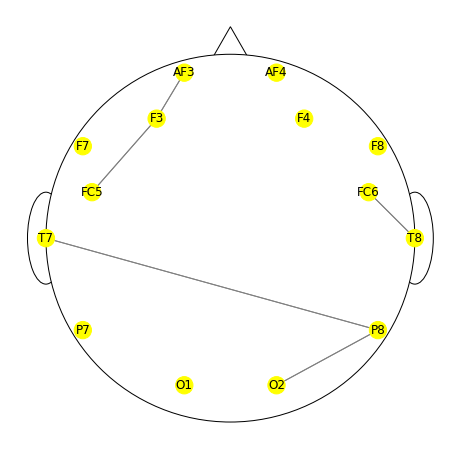

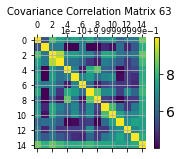

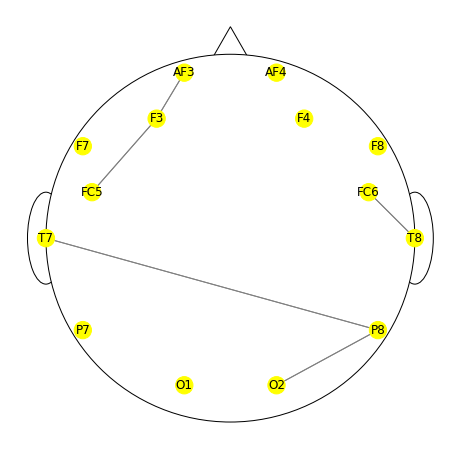

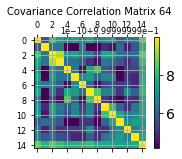

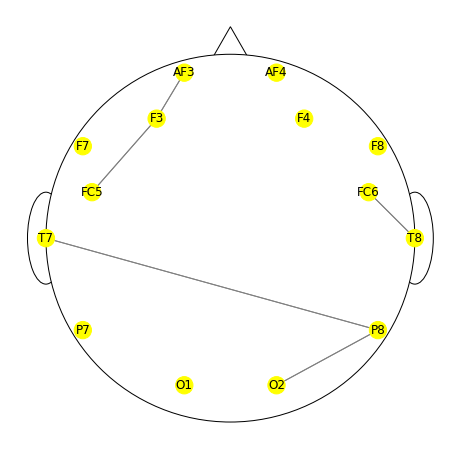

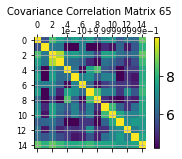

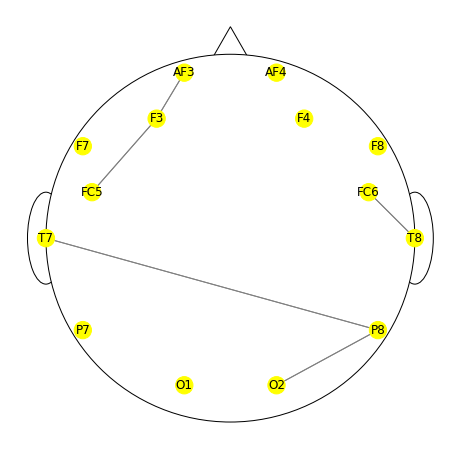

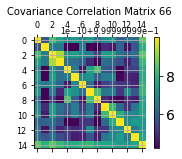

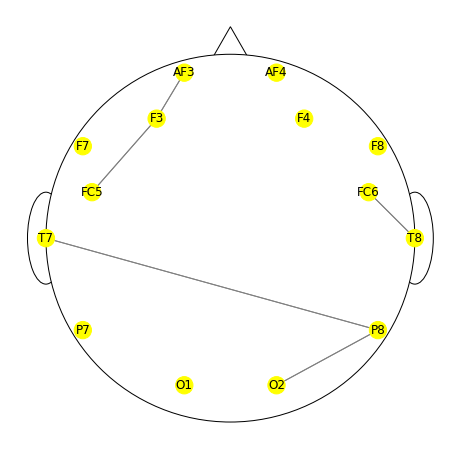

In [16]:
correlated_data.show_figures()

Export The plots

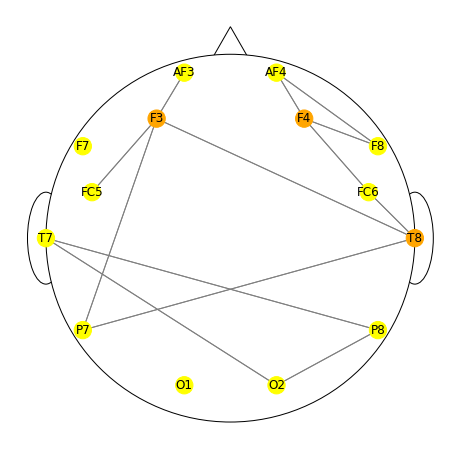

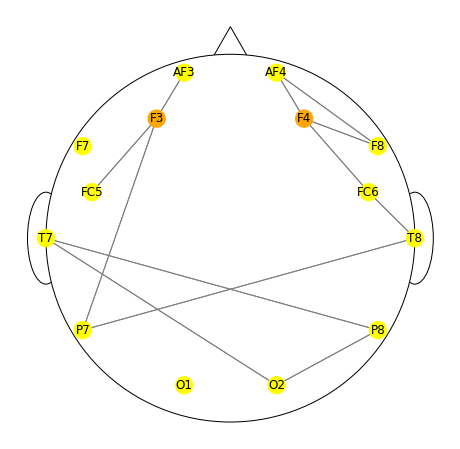

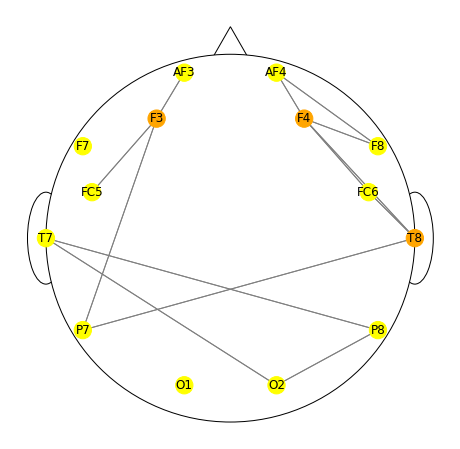

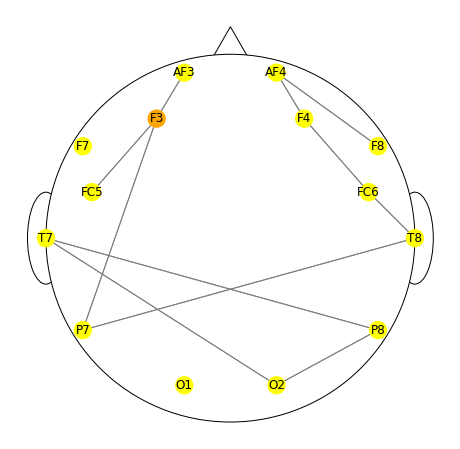

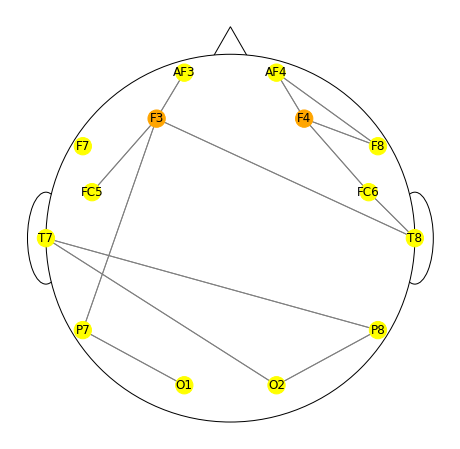

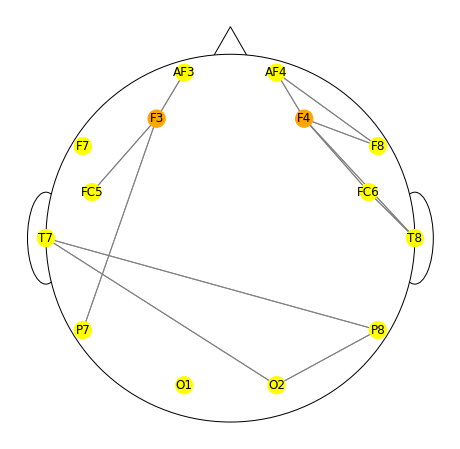

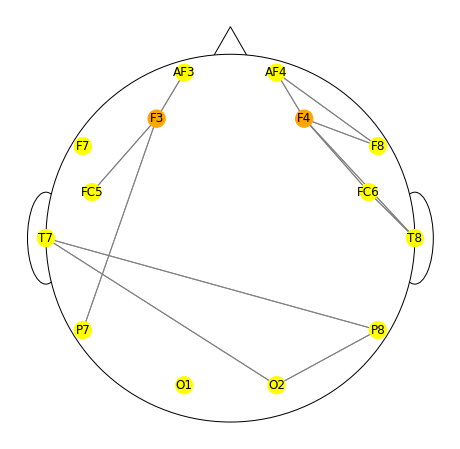

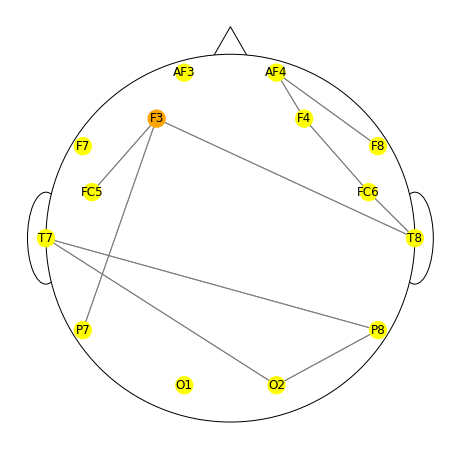

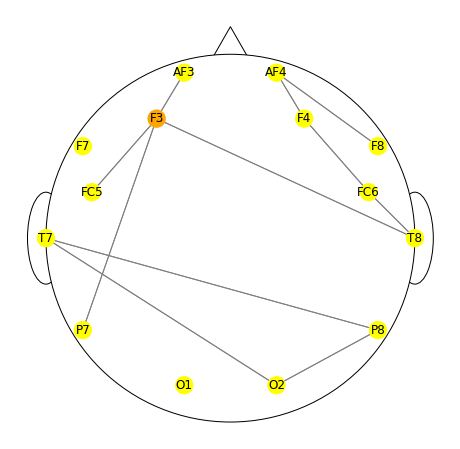

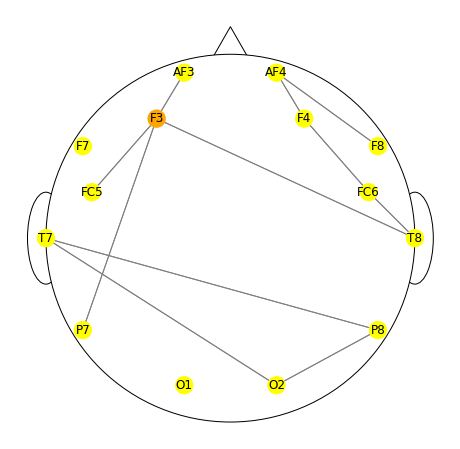

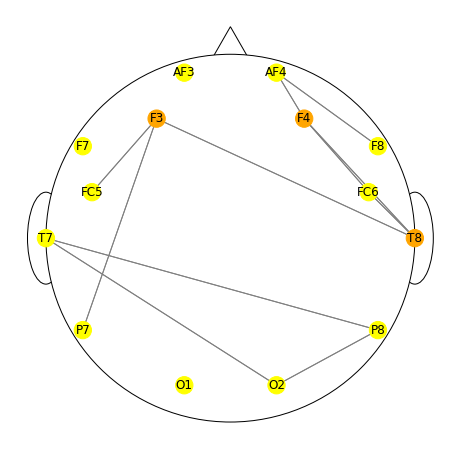

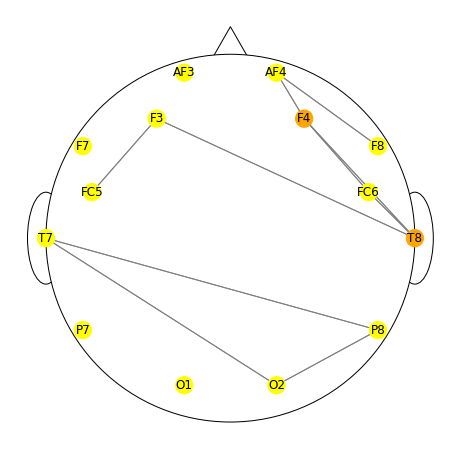

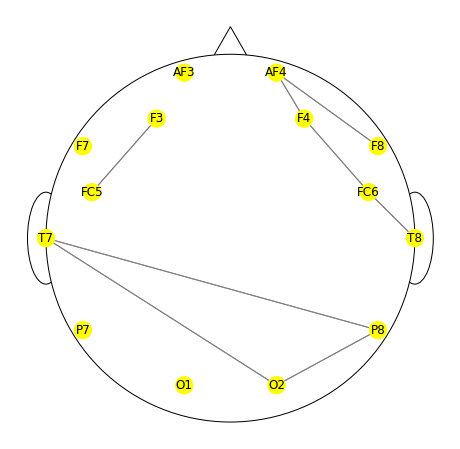

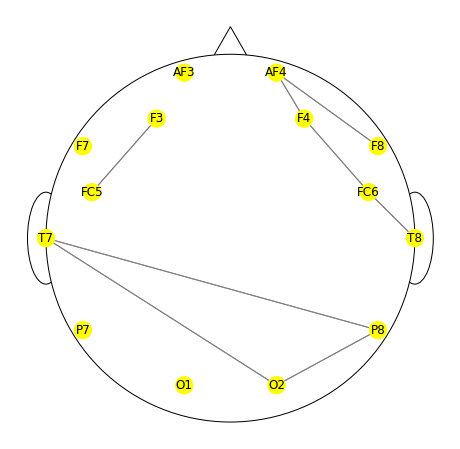

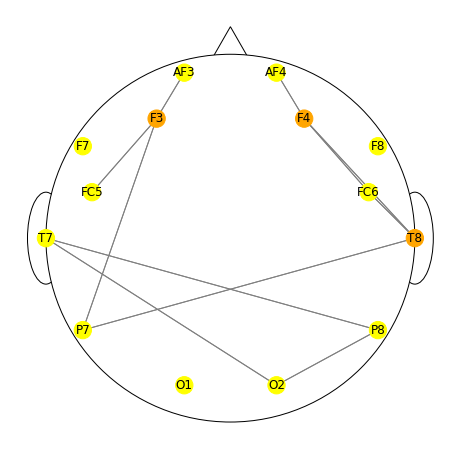

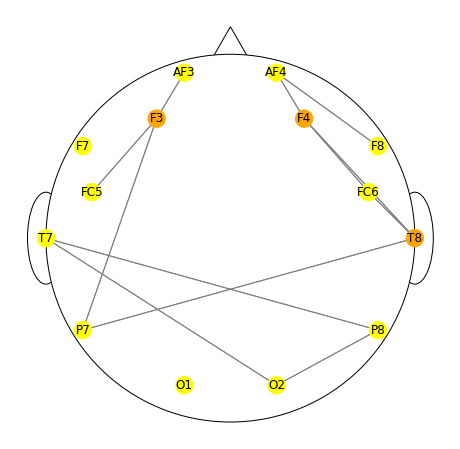

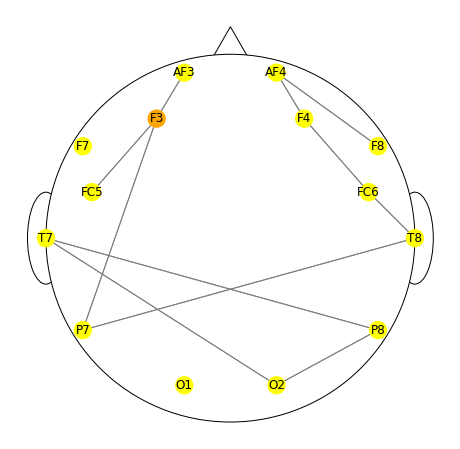

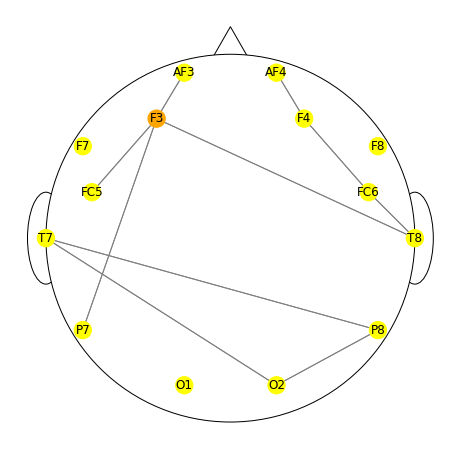

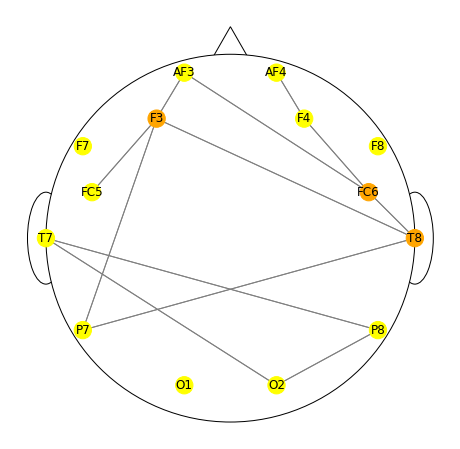

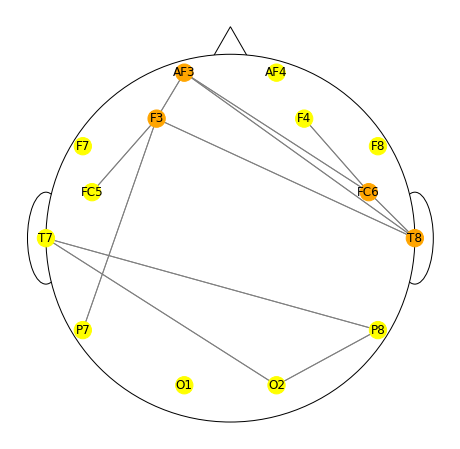

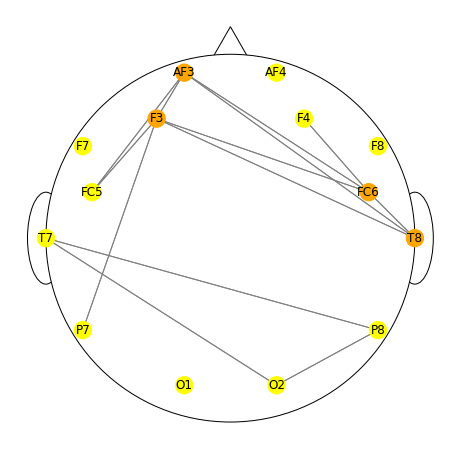

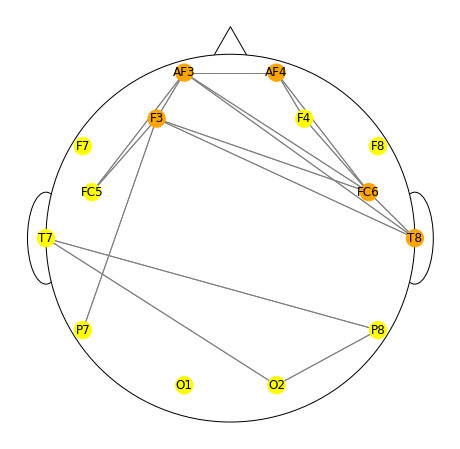

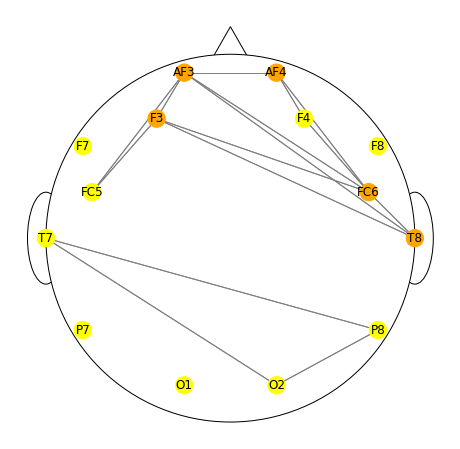

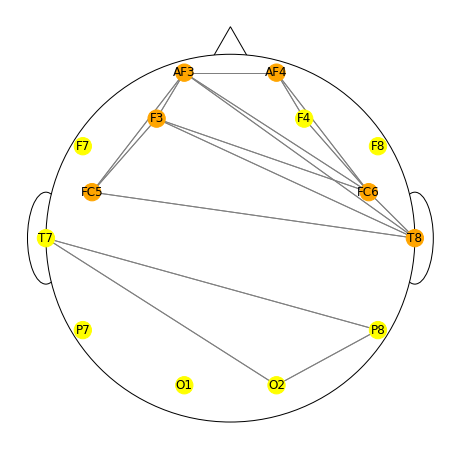

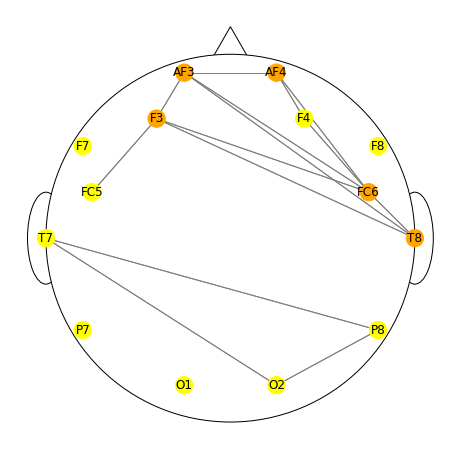

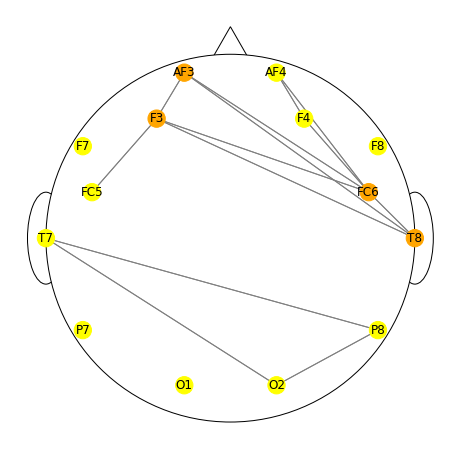

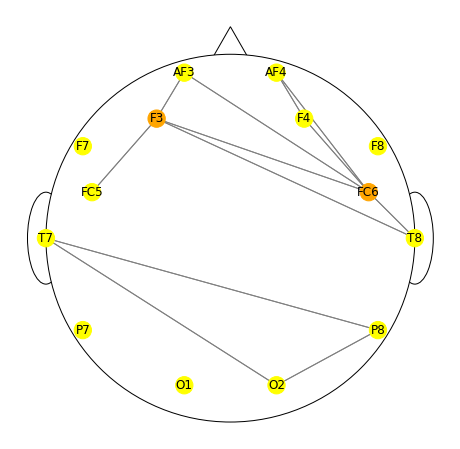

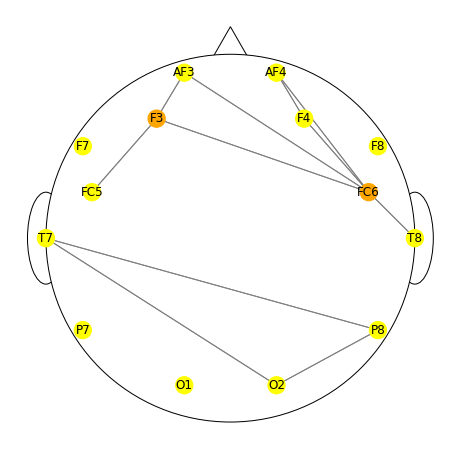

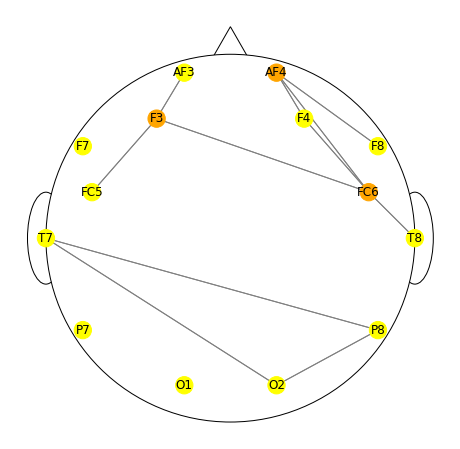

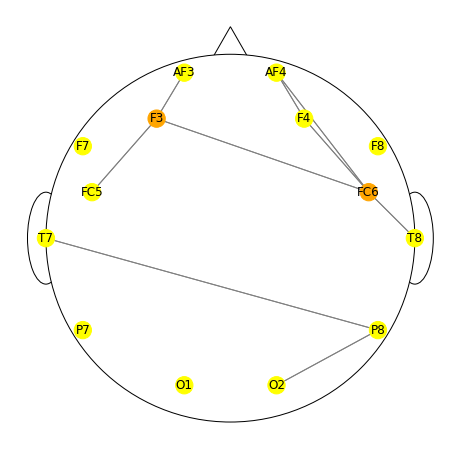

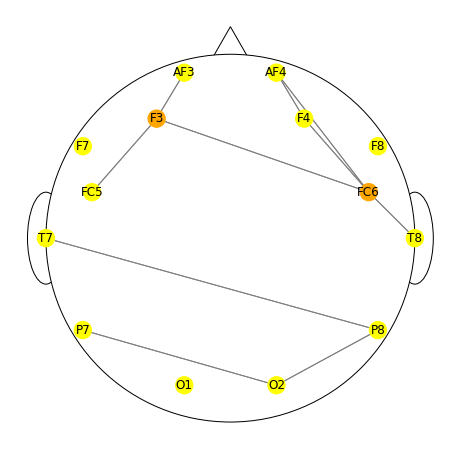

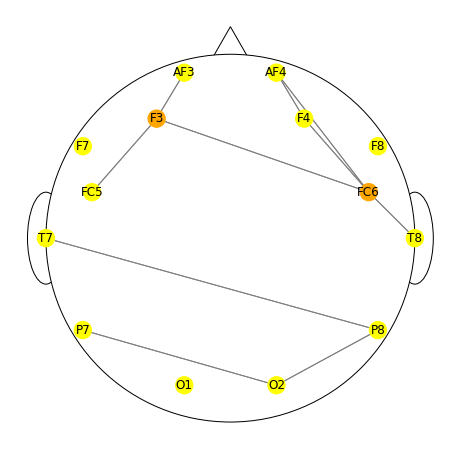

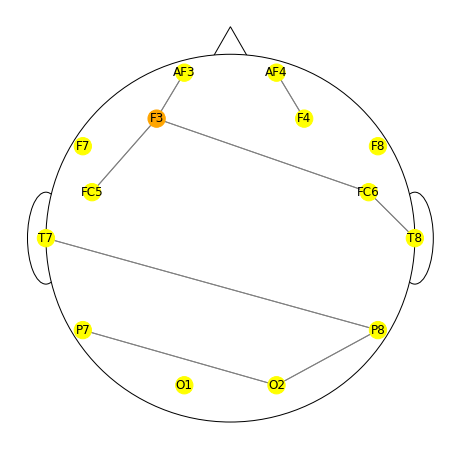

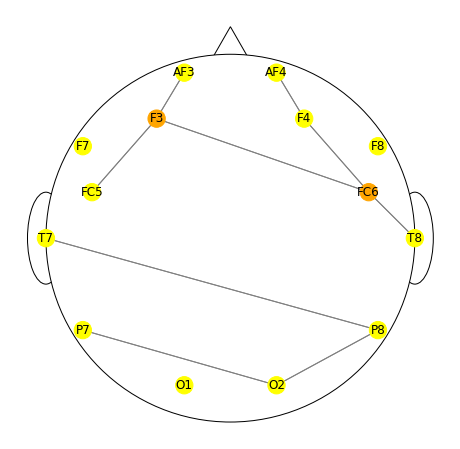

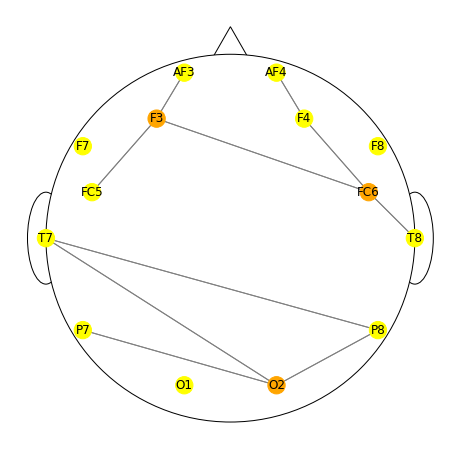

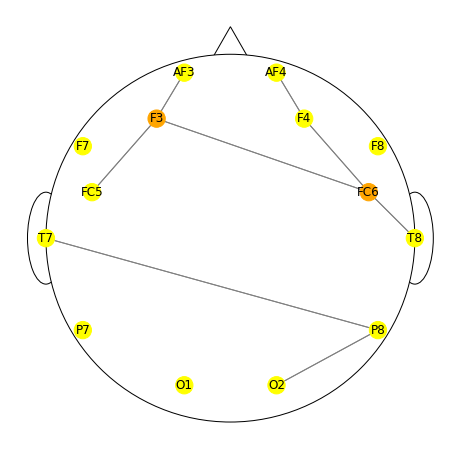

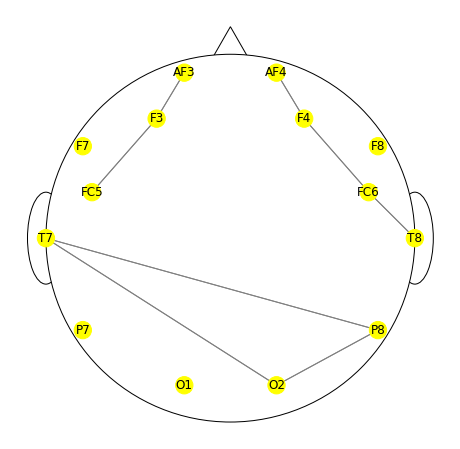

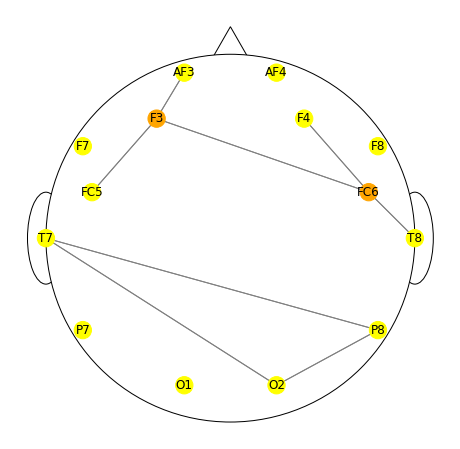

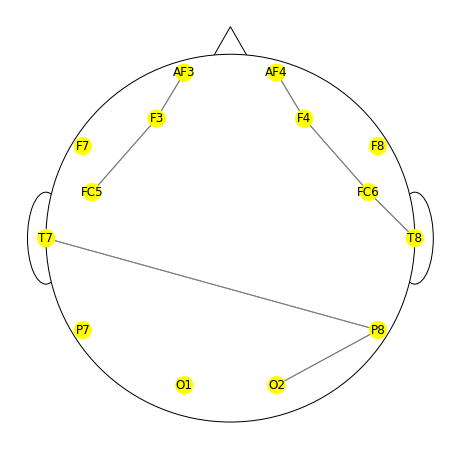

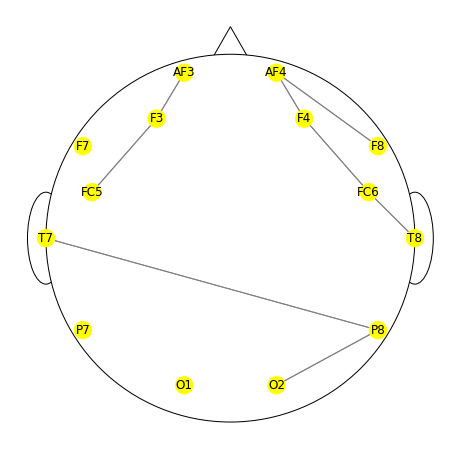

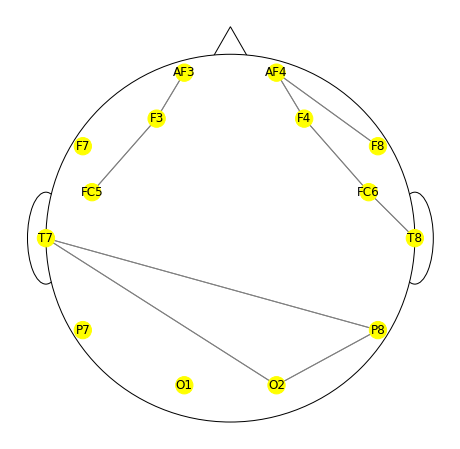

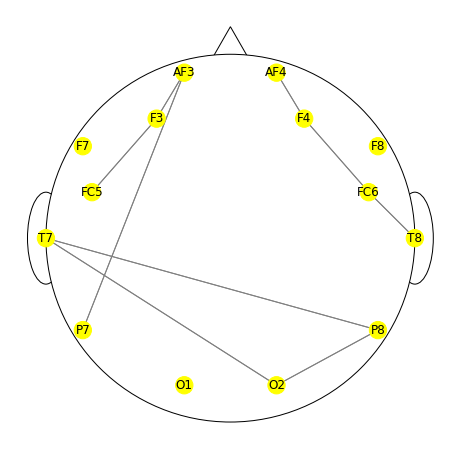

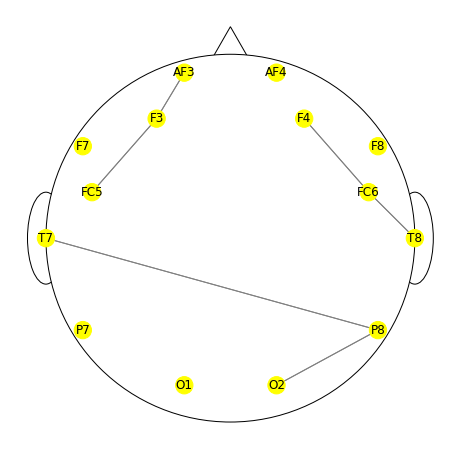

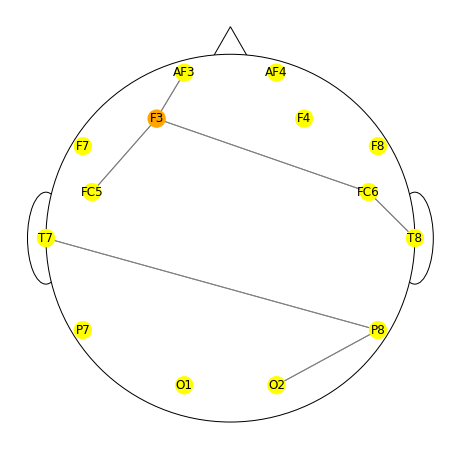

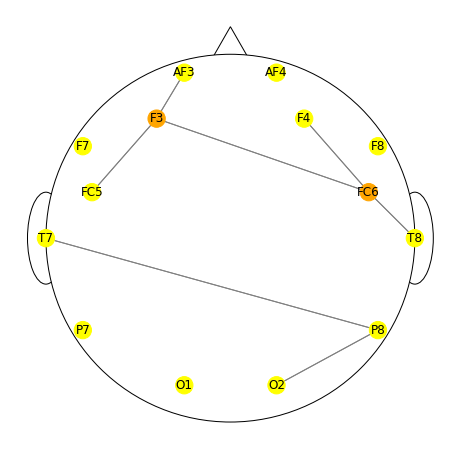

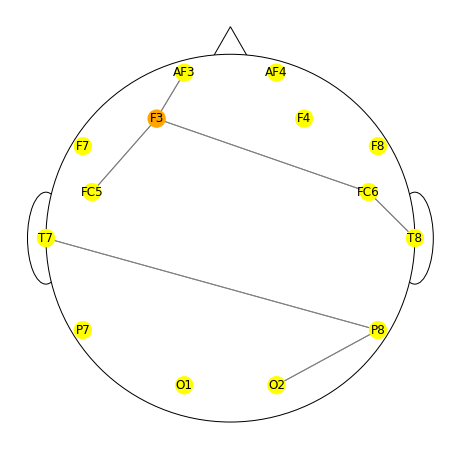

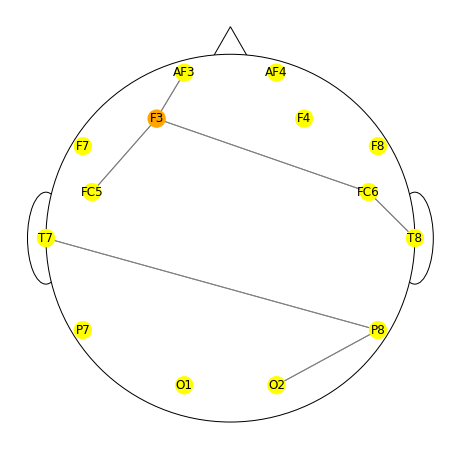

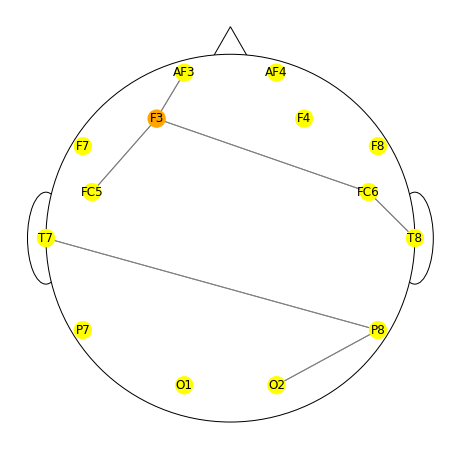

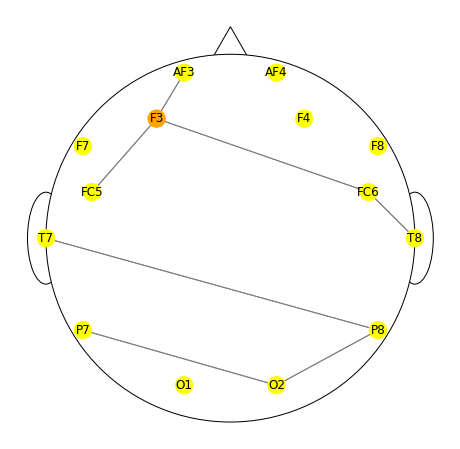

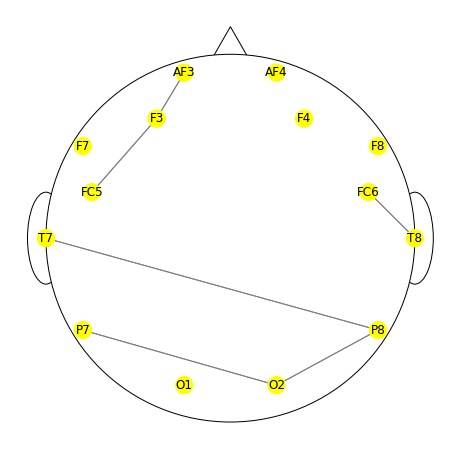

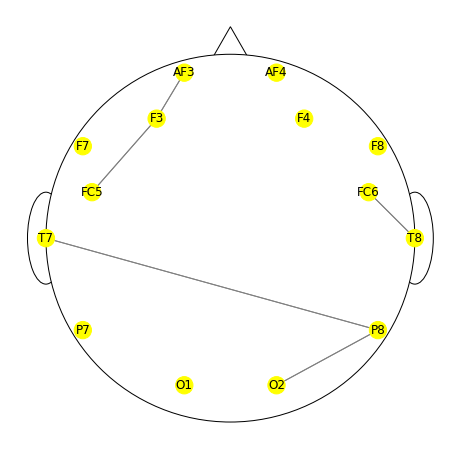

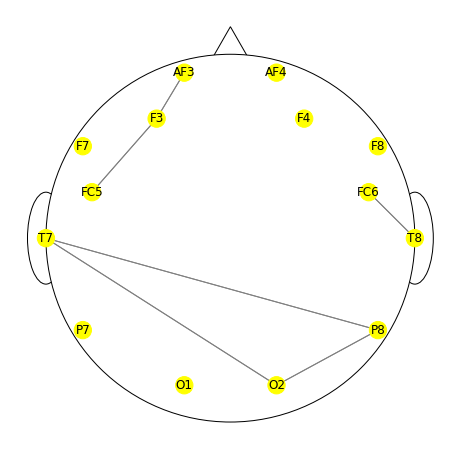

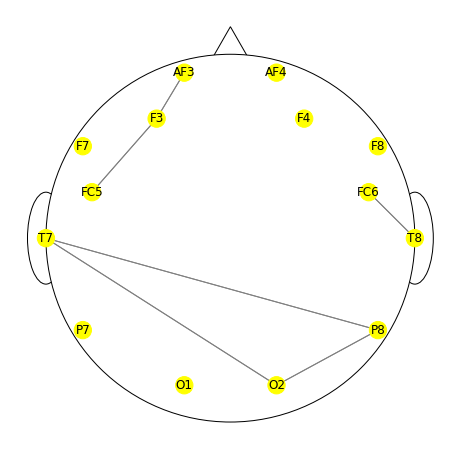

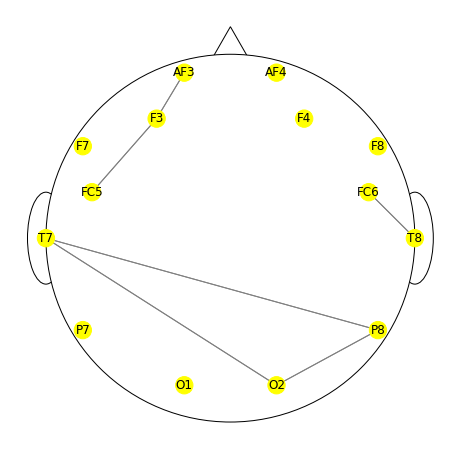

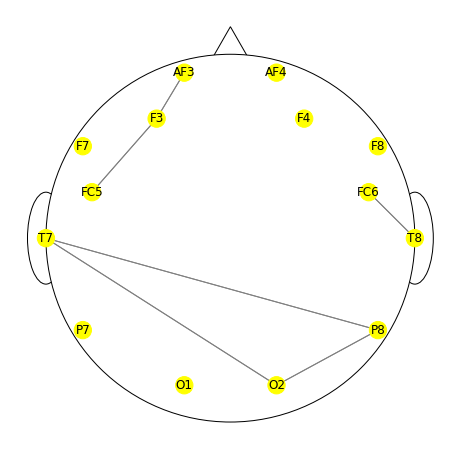

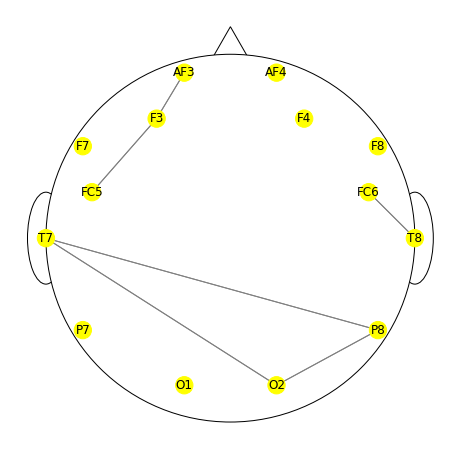

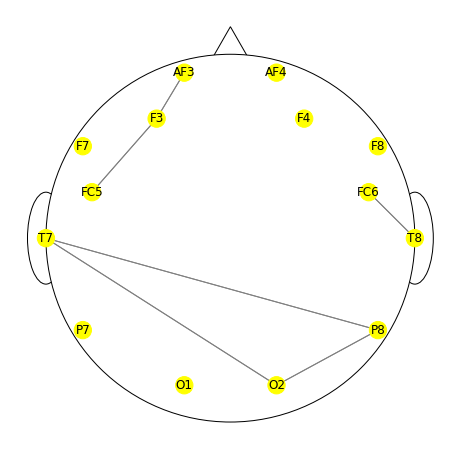

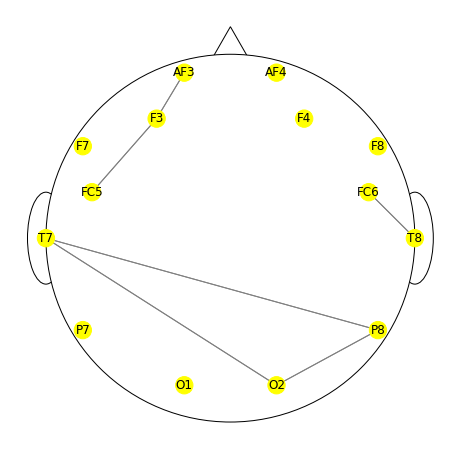

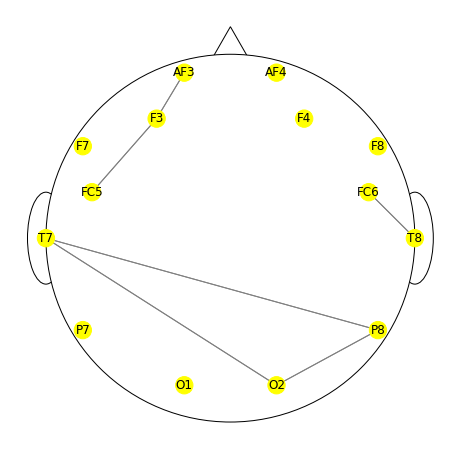

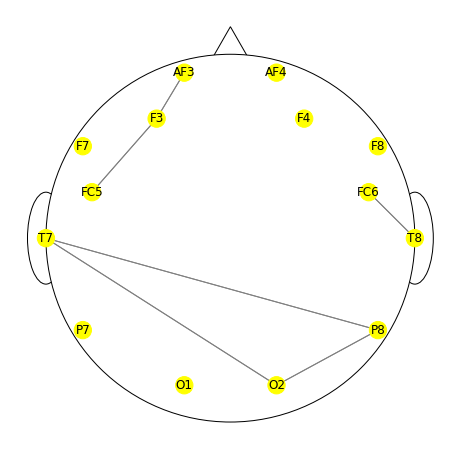

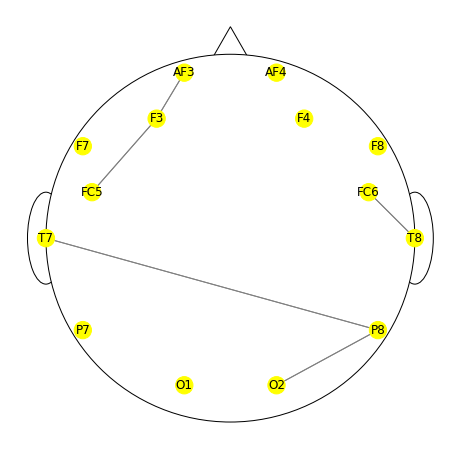

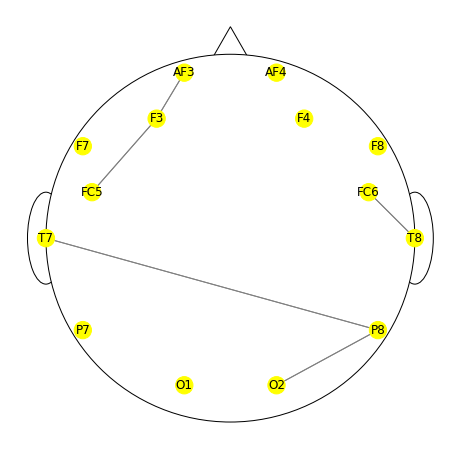

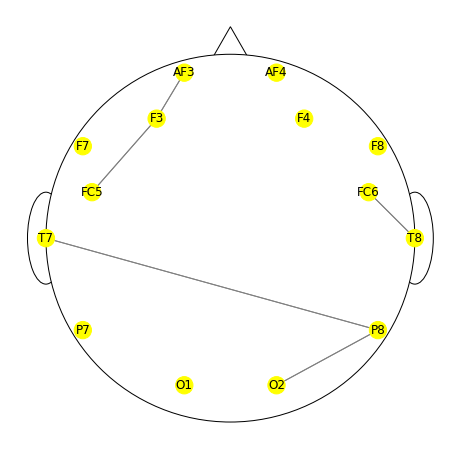

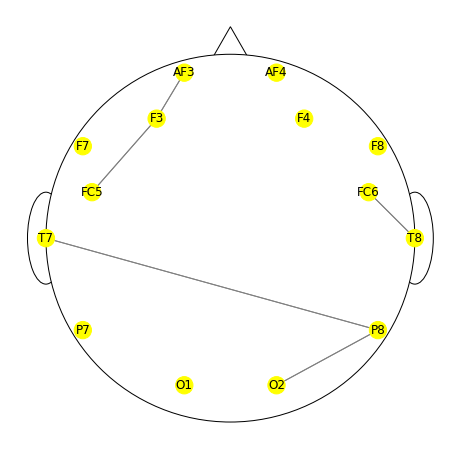

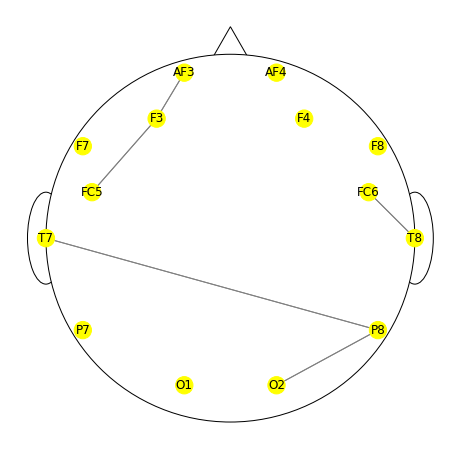

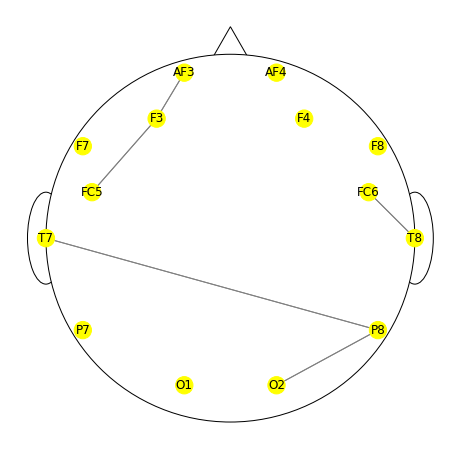

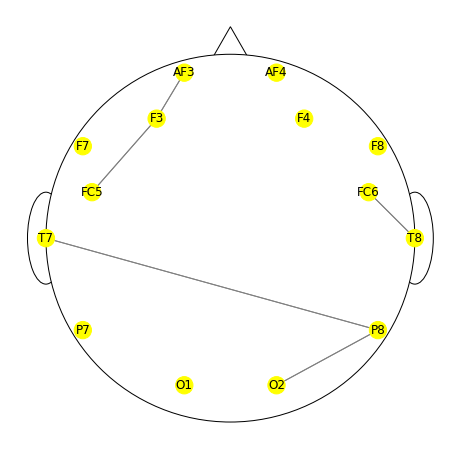

In [17]:
correlated_data.export(edf_file_name)